In [197]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Machine Learning 
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, auc)
from sklearn.preprocessing import StandardScaler

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Hyperparameter Optimization
import optuna

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

In [198]:
# Load balanced and unbalanced datasets
df_balanced = pd.read_csv('Balanced_hotel_data.csv')
df_unbalanced = pd.read_csv('Unbalanced_hotel_data.csv')

# Print basic information about both datasets
print("Balanced Dataset Shape:", df_balanced.shape)
print("Unbalanced Dataset Shape:", df_unbalanced.shape)

# Check class distribution in both datasets
print("\nBalanced Dataset Class Distribution:")
print(df_balanced['is_canceled'].value_counts(normalize=True))
print("\nUnbalanced Dataset Class Distribution:")
print(df_unbalanced['is_canceled'].value_counts(normalize=True))

Balanced Dataset Shape: (47670, 56)
Unbalanced Dataset Shape: (86003, 56)

Balanced Dataset Class Distribution:
is_canceled
0    0.5
1    0.5
Name: proportion, dtype: float64

Unbalanced Dataset Class Distribution:
is_canceled
0    0.722859
1    0.277141
Name: proportion, dtype: float64


In [199]:
def prepare_data(df, test_size=0.2, val_size=0.25, random_state=RANDOM_SEED):

    # Separate features and target
    X = df.drop('is_canceled', axis=1)
    y = df['is_canceled']
    feature_names = X.columns.tolist()
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y
    )
    
    # Second split: separate validation set from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size,
        random_state=random_state,
        stratify=y_temp
    )
    
    print("Training set shape:", X_train.shape)
    print("Validation set shape:", X_val.shape)
    print("Test set shape:", X_test.shape)
    
    return (X_train, X_val, X_test, 
            y_train, y_val, y_test,
            feature_names)

In [200]:
# Prepare balanced dataset
(X_train_balanced, X_val_balanced, X_test_balanced,
 y_train_balanced, y_val_balanced, y_test_balanced,
 feature_names) = prepare_data(df_balanced)

# Prepare unbalanced dataset
(X_train_unbalanced, X_val_unbalanced, X_test_unbalanced,
 y_train_unbalanced, y_val_unbalanced, y_test_unbalanced,
 _) = prepare_data(df_unbalanced)

Training set shape: (28602, 55)
Validation set shape: (9534, 55)
Test set shape: (9534, 55)
Training set shape: (51601, 55)
Validation set shape: (17201, 55)
Test set shape: (17201, 55)


In [201]:
def evaluate_model(y_true, y_pred, y_pred_proba, title="Model Evaluation"):
    """
    Evaluate model performance using multiple metrics and create visualizations.
    
    Args:
        y_true: true labels
        y_pred: predicted labels
        y_pred_proba: predicted probabilities
        title: title for plots
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    # Print metrics
    print(f"\n{title}")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix\n{title}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve\n{title}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [202]:
# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'lambda': 1.0,  # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'colsample_bylevel': 0.8,  # Sampling columns per level
    'colsample_bynode': 0.8,  # Sampling columns per node
    'grow_policy': 'lossguide',  # Growth policy for trees
    'random_state': RANDOM_SEED
}

# K-fold cross-validation parameters
n_splits = 5
early_stopping_rounds = 10

In [203]:
def train_xgboost_with_cv(X_train, y_train, X_val, y_val, params, n_splits=5):
    """
    Train XGBoost model with k-fold cross-validation and early stopping.
    """
    # Create KFold cross-validator
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    # Lists to store cross-validation scores
    cv_scores = {
        'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'train_auc': [],
        'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': []
    }
    
    print("Starting k-fold cross-validation training...")
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
        print(f"\nFold {fold}/{n_splits}")
        print("-" * 30)
        
        # Split data for this fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Create validation set for early stopping
        eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]
        
        # Train model
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=eval_set,
            verbose=False
        )
        
        # Make predictions on training set
        y_train_pred = model.predict(X_train_fold)
        y_train_pred_proba = model.predict_proba(X_train_fold)[:, 1]
        
        # Make predictions on validation set
        y_val_pred = model.predict(X_val_fold)
        y_val_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate training metrics
        cv_scores['train_accuracy'].append(accuracy_score(y_train_fold, y_train_pred))
        cv_scores['train_precision'].append(precision_score(y_train_fold, y_train_pred))
        cv_scores['train_recall'].append(recall_score(y_train_fold, y_train_pred))
        cv_scores['train_f1'].append(f1_score(y_train_fold, y_train_pred))
        cv_scores['train_auc'].append(roc_auc_score(y_train_fold, y_train_pred_proba))
        
        # Calculate validation metrics
        cv_scores['val_accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_scores['val_precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_scores['val_recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_scores['val_f1'].append(f1_score(y_val_fold, y_val_pred))
        cv_scores['val_auc'].append(roc_auc_score(y_val_fold, y_val_pred_proba))
        
        # Print metrics for this fold
        print(f"Training Metrics:")
        print(f"Accuracy: {cv_scores['train_accuracy'][-1]:.4f}")
        print(f"Precision: {cv_scores['train_precision'][-1]:.4f}")
        print(f"Recall: {cv_scores['train_recall'][-1]:.4f}")
        print(f"F1-score: {cv_scores['train_f1'][-1]:.4f}")
        print(f"AUC-ROC: {cv_scores['train_auc'][-1]:.4f}")
        
        print(f"\nValidation Metrics:")
        print(f"Accuracy: {cv_scores['val_accuracy'][-1]:.4f}")
        print(f"Precision: {cv_scores['val_precision'][-1]:.4f}")
        print(f"Recall: {cv_scores['val_recall'][-1]:.4f}")
        print(f"F1-score: {cv_scores['val_f1'][-1]:.4f}")
        print(f"AUC-ROC: {cv_scores['val_auc'][-1]:.4f}")
    
    # Print average cross-validation scores
    print("\nAverage Cross-validation Results:")
    print("-" * 50)
    print("\nTraining Metrics:")
    print(f"Accuracy: {np.mean(cv_scores['train_accuracy']):.4f} (±{np.std(cv_scores['train_accuracy']):.4f})")
    print(f"Precision: {np.mean(cv_scores['train_precision']):.4f} (±{np.std(cv_scores['train_precision']):.4f})")
    print(f"Recall: {np.mean(cv_scores['train_recall']):.4f} (±{np.std(cv_scores['train_recall']):.4f})")
    print(f"F1-score: {np.mean(cv_scores['train_f1']):.4f} (±{np.std(cv_scores['train_f1']):.4f})")
    print(f"AUC-ROC: {np.mean(cv_scores['train_auc']):.4f} (±{np.std(cv_scores['train_auc']):.4f})")
    
    print("\nValidation Metrics:")
    print(f"Accuracy: {np.mean(cv_scores['val_accuracy']):.4f} (±{np.std(cv_scores['val_accuracy']):.4f})")
    print(f"Precision: {np.mean(cv_scores['val_precision']):.4f} (±{np.std(cv_scores['val_precision']):.4f})")
    print(f"Recall: {np.mean(cv_scores['val_recall']):.4f} (±{np.std(cv_scores['val_recall']):.4f})")
    print(f"F1-score: {np.mean(cv_scores['val_f1']):.4f} (±{np.std(cv_scores['val_f1']):.4f})")
    print(f"AUC-ROC: {np.mean(cv_scores['val_auc']):.4f} (±{np.std(cv_scores['val_auc']):.4f})")
    
    # Train final model on full training data
    final_model = xgb.XGBClassifier(**params)
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    return final_model, cv_scores

In [204]:
print("\nTraining XGBoost on unbalanced dataset...")
xgb_model_unbalanced, cv_scores_unbalanced = train_xgboost_with_cv(
    X_train_unbalanced, y_train_unbalanced,
    X_val_unbalanced, y_val_unbalanced,
    xgb_params
)


Training XGBoost on unbalanced dataset...
Starting k-fold cross-validation training...

Fold 1/5
------------------------------
Training Metrics:
Accuracy: 0.8163
Precision: 0.7412
Recall: 0.5179
F1-score: 0.6098
AUC-ROC: 0.8657

Validation Metrics:
Accuracy: 0.8064
Precision: 0.7189
Recall: 0.4953
F1-score: 0.5865
AUC-ROC: 0.8469

Fold 2/5
------------------------------
Training Metrics:
Accuracy: 0.8124
Precision: 0.7360
Recall: 0.5041
F1-score: 0.5983
AUC-ROC: 0.8633

Validation Metrics:
Accuracy: 0.8149
Precision: 0.7431
Recall: 0.5077
F1-score: 0.6032
AUC-ROC: 0.8454

Fold 3/5
------------------------------
Training Metrics:
Accuracy: 0.8170
Precision: 0.7439
Recall: 0.5179
F1-score: 0.6106
AUC-ROC: 0.8651

Validation Metrics:
Accuracy: 0.8055
Precision: 0.7195
Recall: 0.4888
F1-score: 0.5821
AUC-ROC: 0.8409

Fold 4/5
------------------------------
Training Metrics:
Accuracy: 0.8172
Precision: 0.7461
Recall: 0.5159
F1-score: 0.6100
AUC-ROC: 0.8655

Validation Metrics:
Accuracy: 0

In [205]:
# Train models on both datasets
print("Training XGBoost on balanced dataset...")
xgb_model_balanced, cv_scores_balanced = train_xgboost_with_cv(
    X_train_balanced, y_train_balanced,
    X_val_balanced, y_val_balanced,
    xgb_params
)

Training XGBoost on balanced dataset...
Starting k-fold cross-validation training...

Fold 1/5
------------------------------
Training Metrics:
Accuracy: 0.7827
Precision: 0.7818
Recall: 0.7845
F1-score: 0.7831
AUC-ROC: 0.8685

Validation Metrics:
Accuracy: 0.7607
Precision: 0.7613
Recall: 0.7594
F1-score: 0.7604
AUC-ROC: 0.8471

Fold 2/5
------------------------------
Training Metrics:
Accuracy: 0.7823
Precision: 0.7782
Recall: 0.7897
F1-score: 0.7839
AUC-ROC: 0.8674

Validation Metrics:
Accuracy: 0.7506
Precision: 0.7481
Recall: 0.7557
F1-score: 0.7519
AUC-ROC: 0.8361

Fold 3/5
------------------------------
Training Metrics:
Accuracy: 0.7807
Precision: 0.7772
Recall: 0.7868
F1-score: 0.7820
AUC-ROC: 0.8683

Validation Metrics:
Accuracy: 0.7528
Precision: 0.7526
Recall: 0.7531
F1-score: 0.7529
AUC-ROC: 0.8342

Fold 4/5
------------------------------
Training Metrics:
Accuracy: 0.7849
Precision: 0.7839
Recall: 0.7868
F1-score: 0.7853
AUC-ROC: 0.8686

Validation Metrics:
Accuracy: 0.75


XGBoost - Unbalanced Dataset (Test Set)
--------------------------------------------------
Accuracy: 0.8042
Precision: 0.7169
Recall: 0.4850
F1-score: 0.5786
AUC-ROC: 0.8418

Classification Report:
              precision    recall  f1-score   support

           0     0.8243    0.9266    0.8725     12434
           1     0.7169    0.4850    0.5786      4767

    accuracy                         0.8042     17201
   macro avg     0.7706    0.7058    0.7255     17201
weighted avg     0.7946    0.8042    0.7910     17201



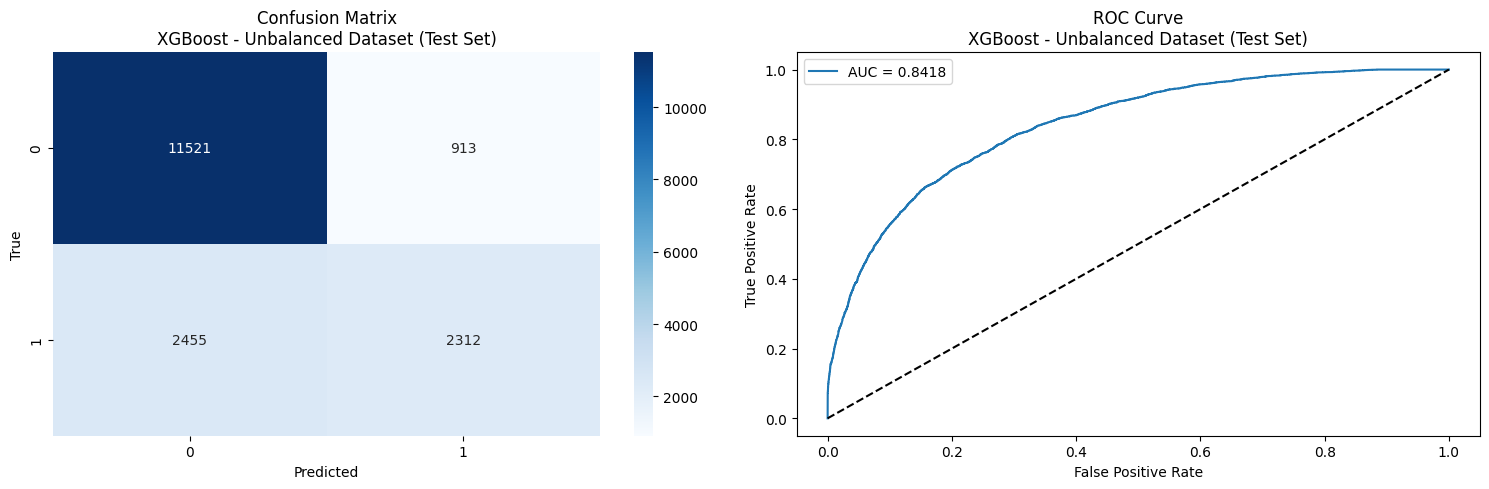

In [206]:
# Evaluate unbalanced model
y_pred_unbalanced = xgb_model_unbalanced.predict(X_test_unbalanced)
y_pred_proba_unbalanced = xgb_model_unbalanced.predict_proba(X_test_unbalanced)[:, 1]

evaluate_model(
    y_test_unbalanced, 
    y_pred_unbalanced, 
    y_pred_proba_unbalanced,
    "XGBoost - Unbalanced Dataset (Test Set)"
)


XGBoost - Balanced Dataset (Test Set)
--------------------------------------------------
Accuracy: 0.7579
Precision: 0.7549
Recall: 0.7638
F1-score: 0.7593
AUC-ROC: 0.8412

Classification Report:
              precision    recall  f1-score   support

           0     0.7610    0.7520    0.7565      4767
           1     0.7549    0.7638    0.7593      4767

    accuracy                         0.7579      9534
   macro avg     0.7580    0.7579    0.7579      9534
weighted avg     0.7580    0.7579    0.7579      9534



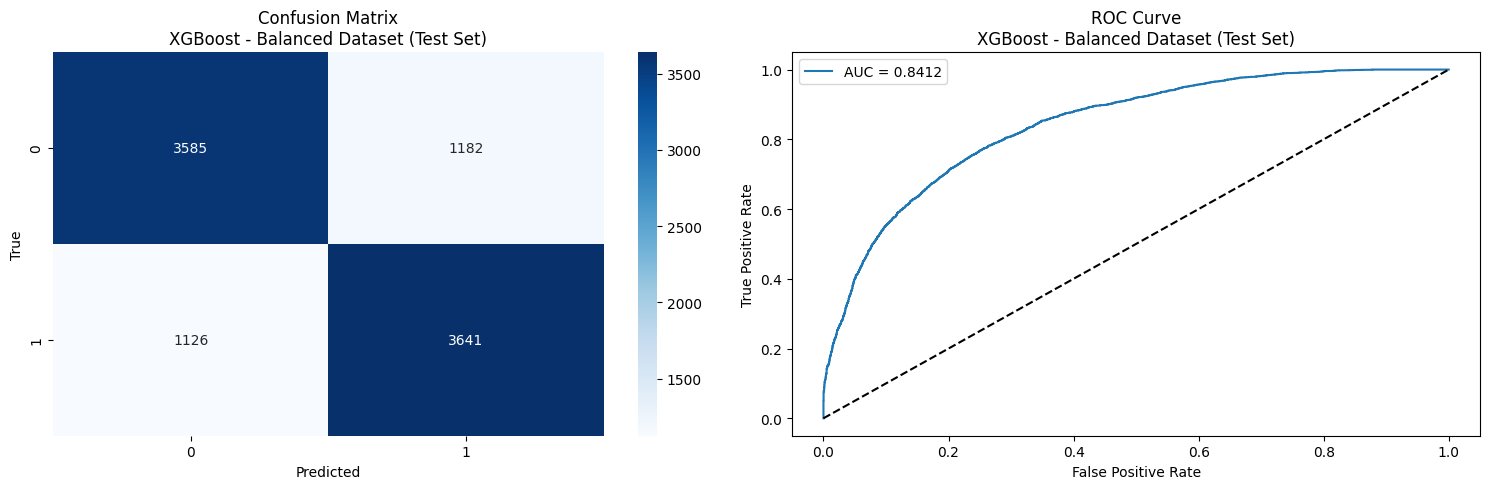

In [207]:
# Evaluate balanced model
y_pred_balanced = xgb_model_balanced.predict(X_test_balanced)
y_pred_proba_balanced = xgb_model_balanced.predict_proba(X_test_balanced)[:, 1]

evaluate_model(
    y_test_balanced, 
    y_pred_balanced, 
    y_pred_proba_balanced,
    "XGBoost - Balanced Dataset (Test Set)"
)


In [208]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(30), x='importance', y='feature')
    plt.title(f"{title}\n(Top 30 Features)")
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return importance_df

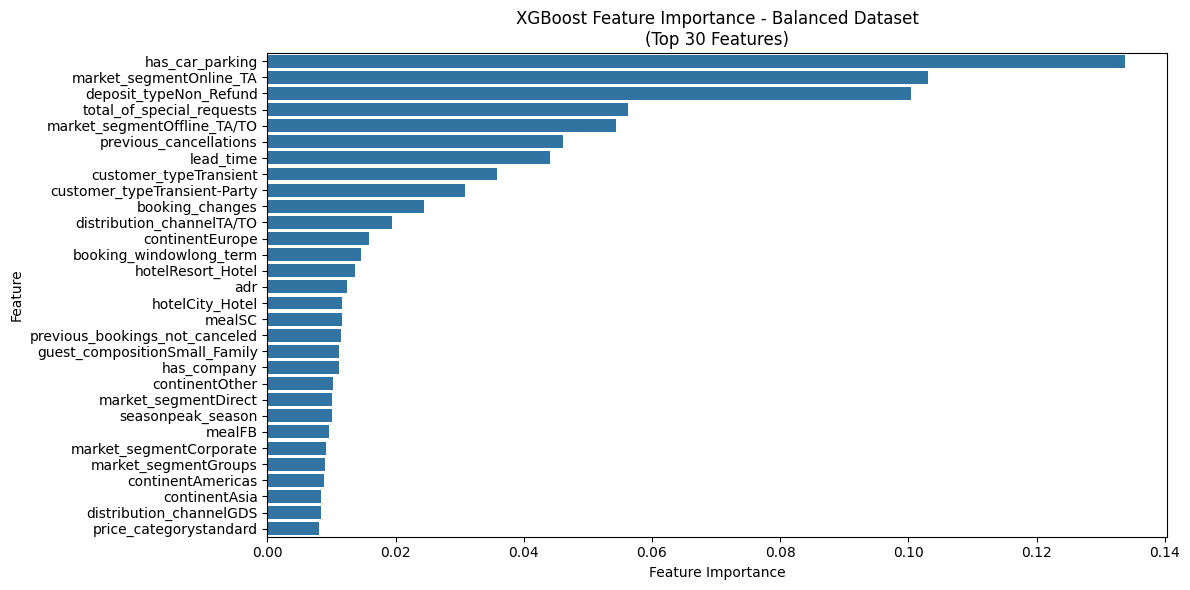

In [209]:
# Plot feature importance for both models
importance_balanced = plot_feature_importance(
    xgb_model_balanced, 
    feature_names,
    "XGBoost Feature Importance - Balanced Dataset"
)

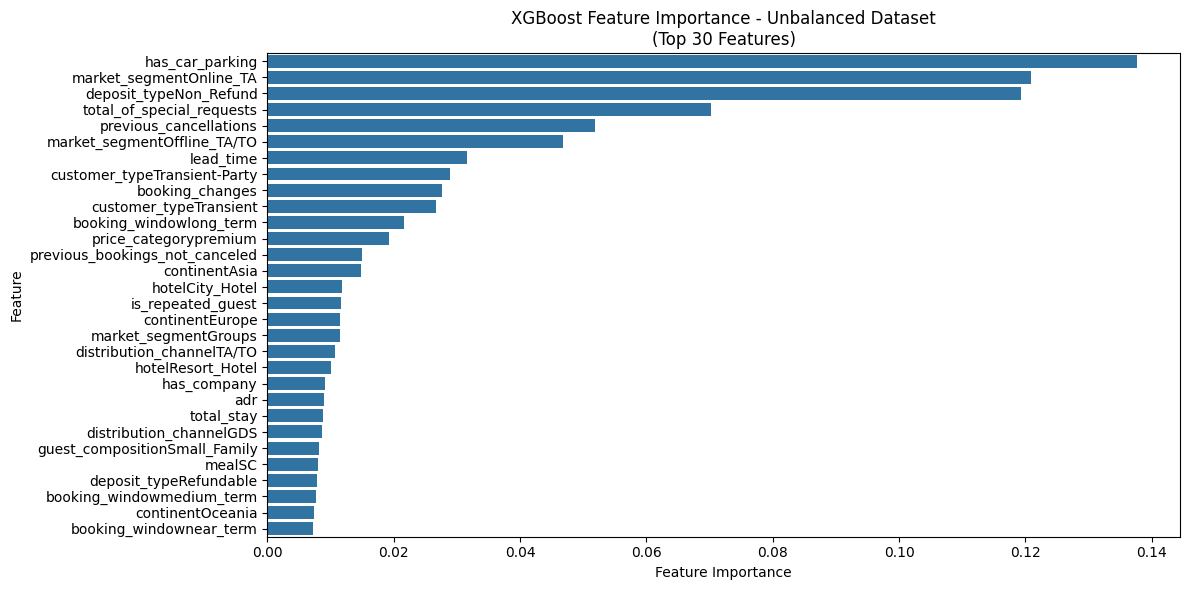

In [210]:
importance_unbalanced = plot_feature_importance(
    xgb_model_unbalanced, 
    feature_names,
    "XGBoost Feature Importance - Unbalanced Dataset"
)

In [257]:
# Enhanced hyperparameter search space for XGBoost
xgb_param_space = {
    # Tree-specific parameters
    'max_depth': (4, 8),        
    'min_child_weight': (1, 5), 
    'gamma': (0, 0.5),          
    
    # Sampling parameters
    'subsample': (0.7, 0.9),    
    'colsample_bytree': (0.7, 0.9),  
    'colsample_bylevel': (0.7, 0.9), 
    'colsample_bynode': (0.7, 0.9),  
    
    # Learning parameters
    'learning_rate': (0.05, 0.15), 
    'n_estimators': (100, 300),    
    
    # Regularization parameters
    'reg_alpha': (0.05, 0.2),     
    'reg_lambda': (0.8, 1.2),    
}

# Fixed parameters that won't be tuned
xgb_fixed_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'grow_policy': 'lossguide',
    'random_state': RANDOM_SEED
}

In [258]:
def objective_xgb(trial, X_train, y_train, X_val, y_val):
    """
    Enhanced Optuna objective function for XGBoost hyperparameter optimization.
    """
    # Construct hyperparameter dictionary for this trial
    params = {
        # Add fixed parameters
        **xgb_fixed_params,
        
        # Sample hyperparameters for this trial
        'max_depth': trial.suggest_int('max_depth', *xgb_param_space['max_depth']),
        'min_child_weight': trial.suggest_int('min_child_weight', *xgb_param_space['min_child_weight']),
        'gamma': trial.suggest_float('gamma', *xgb_param_space['gamma']),
        'subsample': trial.suggest_float('subsample', *xgb_param_space['subsample']),
        'colsample_bytree': trial.suggest_float('colsample_bytree', *xgb_param_space['colsample_bytree']),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', *xgb_param_space['colsample_bylevel']),
        'colsample_bynode': trial.suggest_float('colsample_bynode', *xgb_param_space['colsample_bynode']),
        'learning_rate': trial.suggest_float('learning_rate', *xgb_param_space['learning_rate']),
        'n_estimators': trial.suggest_int('n_estimators', *xgb_param_space['n_estimators']),
        'reg_alpha': trial.suggest_float('reg_alpha', *xgb_param_space['reg_alpha']),
        'reg_lambda': trial.suggest_float('reg_lambda', *xgb_param_space['reg_lambda'])
    }
    
    # Use early stopping in cross-validation
    early_stopping_rounds = 10
    
    # Perform cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    cv_scores = []
    
    for train_idx, val_idx in kfold.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Train model with early stopping
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=False
        )
        
        # Evaluate using both recall and precision (balanced performance)
        y_pred = model.predict(X_val_fold)
        fold_recall = recall_score(y_val_fold, y_pred)
        fold_precision = precision_score(y_val_fold, y_pred)
        fold_f1 = 2 * (fold_precision * fold_recall) / (fold_precision + fold_recall)
        cv_scores.append(fold_f1)
    
    # Return mean cross-validation f1-score
    return np.mean(cv_scores)

In [259]:
# Define the hyperparameter search space for XGBoost
def optimize_xgboost(X_train, y_train, X_val, y_val, n_trials=100):
    """
    Run Optuna optimization for XGBoost hyperparameters.
    """
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': RANDOM_SEED,
            
            # Tree-specific parameters
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'gamma': trial.suggest_float('gamma', 0, 1),
            
            # Sampling parameters
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            
            # Learning parameters
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            
            # Regularization parameters
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
        }
        
        # Perform cross-validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
        cv_scores = []
        
        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # Train model
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                verbose=False
            )
            
            # Evaluate
            y_pred = model.predict(X_val_fold)
            fold_recall = recall_score(y_val_fold, y_pred)
            cv_scores.append(fold_recall)
        
        # Print current trial results
        mean_recall = np.mean(cv_scores)
        print(f"Trial {trial.number}: Mean Recall = {mean_recall:.4f}")
        return mean_recall

    # Create and run study
    study = optuna.create_study(direction='maximize')
    print(f"\nStarting hyperparameter optimization with {n_trials} trials...")
    print("Parameters being optimized:")
    print("- max_depth (3-10)")
    print("- min_child_weight (1-7)")
    print("- gamma (0-1)")
    print("- subsample (0.6-1.0)")
    print("- colsample_bytree (0.6-1.0)")
    print("- learning_rate (0.01-0.3)")
    print("- n_estimators (100-500)")
    print("- reg_alpha (0-1)")
    print("- reg_lambda (0-1)")
    print("\nOptimizing for mean recall score across 5-fold CV")
    print("-" * 50)
    
    study.optimize(objective, n_trials=n_trials)
    
    print("\nOptimization completed!")
    print("\nBest trial:")
    trial = study.best_trial
    
    print(f"  Best Mean Recall: {trial.value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
        
    # Plot optimization history
    plt.figure(figsize=(10, 6))
    plt.plot(study.trials_dataframe()['value'])
    plt.xlabel('Trial')
    plt.ylabel('Mean Recall')
    plt.title('Optimization History')
    plt.show()
    
    return study.best_params

[I 2024-12-30 18:27:30,130] A new study created in memory with name: no-name-a44d1246-f56c-4ad1-9de0-989bcda5a8fb


Optimizing XGBoost hyperparameters for balanced dataset...

Starting hyperparameter optimization with 100 trials...
Parameters being optimized:
- max_depth (3-10)
- min_child_weight (1-7)
- gamma (0-1)
- subsample (0.6-1.0)
- colsample_bytree (0.6-1.0)
- learning_rate (0.01-0.3)
- n_estimators (100-500)
- reg_alpha (0-1)
- reg_lambda (0-1)

Optimizing for mean recall score across 5-fold CV
--------------------------------------------------


[I 2024-12-30 18:27:32,759] Trial 0 finished with value: 0.750087088723929 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.37127192961074784, 'subsample': 0.6937601434355039, 'colsample_bytree': 0.7060026012441869, 'learning_rate': 0.2513754823621168, 'n_estimators': 156, 'reg_alpha': 0.8737644160159507, 'reg_lambda': 0.6714472688993391}. Best is trial 0 with value: 0.750087088723929.


Trial 0: Mean Recall = 0.7501


[I 2024-12-30 18:27:37,450] Trial 1 finished with value: 0.7703660757278372 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.5089329306984619, 'subsample': 0.9434512787625078, 'colsample_bytree': 0.7326017496018213, 'learning_rate': 0.012663453802473718, 'n_estimators': 498, 'reg_alpha': 0.9325233751847246, 'reg_lambda': 0.07291321653197436}. Best is trial 1 with value: 0.7703660757278372.


Trial 1: Mean Recall = 0.7704


[I 2024-12-30 18:27:41,544] Trial 2 finished with value: 0.7595272570840553 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.520531423039995, 'subsample': 0.6663332955846116, 'colsample_bytree': 0.6008430907888279, 'learning_rate': 0.08373791401536232, 'n_estimators': 372, 'reg_alpha': 0.18910135229524494, 'reg_lambda': 0.545994941740362}. Best is trial 1 with value: 0.7703660757278372.


Trial 2: Mean Recall = 0.7595


[I 2024-12-30 18:27:44,019] Trial 3 finished with value: 0.759037771037072 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.8938833933842839, 'subsample': 0.9719545476227656, 'colsample_bytree': 0.6366202604431462, 'learning_rate': 0.22140950402560908, 'n_estimators': 238, 'reg_alpha': 0.16407434586784397, 'reg_lambda': 0.46474579914630565}. Best is trial 1 with value: 0.7703660757278372.


Trial 3: Mean Recall = 0.7590


[I 2024-12-30 18:27:46,549] Trial 4 finished with value: 0.7625342012059942 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.6502590322176689, 'subsample': 0.71567165518668, 'colsample_bytree': 0.6725586364040352, 'learning_rate': 0.02977880951262944, 'n_estimators': 244, 'reg_alpha': 0.7840180842455556, 'reg_lambda': 0.6911686883763609}. Best is trial 1 with value: 0.7703660757278372.


Trial 4: Mean Recall = 0.7625


[I 2024-12-30 18:27:49,123] Trial 5 finished with value: 0.7586186794680329 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.5754329850587313, 'subsample': 0.7360547183314186, 'colsample_bytree': 0.863649031039466, 'learning_rate': 0.09865964706949373, 'n_estimators': 195, 'reg_alpha': 0.597009230605973, 'reg_lambda': 0.5399533761803021}. Best is trial 1 with value: 0.7703660757278372.


Trial 5: Mean Recall = 0.7586


[I 2024-12-30 18:27:51,019] Trial 6 finished with value: 0.7568705010473622 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.7909416929359222, 'subsample': 0.6836900768834397, 'colsample_bytree': 0.7044249155145164, 'learning_rate': 0.14545214628581232, 'n_estimators': 139, 'reg_alpha': 0.09661172787549688, 'reg_lambda': 0.20130670954448238}. Best is trial 1 with value: 0.7703660757278372.


Trial 6: Mean Recall = 0.7569


[I 2024-12-30 18:27:52,873] Trial 7 finished with value: 0.759877347399193 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.9766895727084972, 'subsample': 0.6536179087433921, 'colsample_bytree': 0.748454161654503, 'learning_rate': 0.04306523697009964, 'n_estimators': 126, 'reg_alpha': 0.1781533324187663, 'reg_lambda': 0.39480549970774503}. Best is trial 1 with value: 0.7703660757278372.


Trial 7: Mean Recall = 0.7599


[I 2024-12-30 18:27:58,080] Trial 8 finished with value: 0.7620446418314295 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.4522097535802134, 'subsample': 0.7525816270080405, 'colsample_bytree': 0.9383956551961791, 'learning_rate': 0.05371767442999916, 'n_estimators': 356, 'reg_alpha': 0.7601636109059918, 'reg_lambda': 0.3550242297660483}. Best is trial 1 with value: 0.7703660757278372.


Trial 8: Mean Recall = 0.7620


[I 2024-12-30 18:28:01,981] Trial 9 finished with value: 0.7660304358347 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.086737801438445, 'subsample': 0.8750515891617912, 'colsample_bytree': 0.64010827708871, 'learning_rate': 0.01437693824393096, 'n_estimators': 231, 'reg_alpha': 0.7467556710394628, 'reg_lambda': 0.05917171023172618}. Best is trial 1 with value: 0.7703660757278372.


Trial 9: Mean Recall = 0.7660


[I 2024-12-30 18:28:07,184] Trial 10 finished with value: 0.758339154728529 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.20205783073996453, 'subsample': 0.9999347336223755, 'colsample_bytree': 0.8191676246437842, 'learning_rate': 0.012073587322727616, 'n_estimators': 495, 'reg_alpha': 0.9978349233323649, 'reg_lambda': 0.935767399718065}. Best is trial 1 with value: 0.7703660757278372.


Trial 10: Mean Recall = 0.7583


[I 2024-12-30 18:28:14,287] Trial 11 finished with value: 0.7657506911124526 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.06684837854597381, 'subsample': 0.8786685078837312, 'colsample_bytree': 0.7785399104245323, 'learning_rate': 0.013344094604230578, 'n_estimators': 476, 'reg_alpha': 0.5272227928208378, 'reg_lambda': 0.026394583856046663}. Best is trial 1 with value: 0.7703660757278372.


Trial 11: Mean Recall = 0.7658


[I 2024-12-30 18:28:18,000] Trial 12 finished with value: 0.7579194276537862 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.2508310787484272, 'subsample': 0.8867347863564036, 'colsample_bytree': 0.6568598585572958, 'learning_rate': 0.020726271035059647, 'n_estimators': 318, 'reg_alpha': 0.6860217625699943, 'reg_lambda': 0.0036848253002876863}. Best is trial 1 with value: 0.7703660757278372.


Trial 12: Mean Recall = 0.7579


[I 2024-12-30 18:28:24,365] Trial 13 finished with value: 0.7649817292110196 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.002127106372930787, 'subsample': 0.8752250410478871, 'colsample_bytree': 0.7509820055142429, 'learning_rate': 0.020007880859410968, 'n_estimators': 420, 'reg_alpha': 0.997764523778332, 'reg_lambda': 0.16868260915508448}. Best is trial 1 with value: 0.7703660757278372.


Trial 13: Mean Recall = 0.7650


[I 2024-12-30 18:28:28,531] Trial 14 finished with value: 0.7588981064374284 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.32297612740795534, 'subsample': 0.9352015169208233, 'colsample_bytree': 0.8351919562405119, 'learning_rate': 0.010900900711920045, 'n_estimators': 271, 'reg_alpha': 0.393718416975112, 'reg_lambda': 0.20527828412128662}. Best is trial 1 with value: 0.7703660757278372.


Trial 14: Mean Recall = 0.7589


[I 2024-12-30 18:28:32,719] Trial 15 finished with value: 0.7621846975115062 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.7118900040884399, 'subsample': 0.7946044819895075, 'colsample_bytree': 0.9930102197588017, 'learning_rate': 0.020349592868588156, 'n_estimators': 430, 'reg_alpha': 0.8870280754731107, 'reg_lambda': 0.11709449834560022}. Best is trial 1 with value: 0.7703660757278372.


Trial 15: Mean Recall = 0.7622


[I 2024-12-30 18:28:35,029] Trial 16 finished with value: 0.7547026688795302 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.4301502336875403, 'subsample': 0.8319597060928322, 'colsample_bytree': 0.601301240771427, 'learning_rate': 0.03125361053588989, 'n_estimators': 198, 'reg_alpha': 0.42217960822805517, 'reg_lambda': 0.346266834543728}. Best is trial 1 with value: 0.7703660757278372.


Trial 16: Mean Recall = 0.7547


[I 2024-12-30 18:28:39,459] Trial 17 finished with value: 0.7612057743025936 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.13628764289059692, 'subsample': 0.9237096054360152, 'colsample_bytree': 0.7211346150919793, 'learning_rate': 0.015436704427071282, 'n_estimators': 309, 'reg_alpha': 0.6650726945264476, 'reg_lambda': 0.25310111124952694}. Best is trial 1 with value: 0.7703660757278372.


Trial 17: Mean Recall = 0.7612


[I 2024-12-30 18:28:43,942] Trial 18 finished with value: 0.7591777289470404 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.2748264711114617, 'subsample': 0.8237097863561362, 'colsample_bytree': 0.8765612576774218, 'learning_rate': 0.029650696991212633, 'n_estimators': 364, 'reg_alpha': 0.8587577056883555, 'reg_lambda': 0.09853681450967444}. Best is trial 1 with value: 0.7703660757278372.


Trial 18: Mean Recall = 0.7592


[I 2024-12-30 18:28:49,274] Trial 19 finished with value: 0.7568008642877571 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.6049087651636373, 'subsample': 0.9330893722145992, 'colsample_bytree': 0.6720782290151979, 'learning_rate': 0.01709025631284827, 'n_estimators': 420, 'reg_alpha': 0.7641053390774406, 'reg_lambda': 0.9443777277816091}. Best is trial 1 with value: 0.7703660757278372.


Trial 19: Mean Recall = 0.7568


[I 2024-12-30 18:28:52,456] Trial 20 finished with value: 0.7598771274164493 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.1575852942244761, 'subsample': 0.7755888707301749, 'colsample_bytree': 0.7798622896116463, 'learning_rate': 0.010028576513021331, 'n_estimators': 185, 'reg_alpha': 0.339052502172273, 'reg_lambda': 0.07720018555060468}. Best is trial 1 with value: 0.7703660757278372.


Trial 20: Mean Recall = 0.7599


[I 2024-12-30 18:29:00,651] Trial 21 finished with value: 0.7647018133910828 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.013699639173124355, 'subsample': 0.8691884901655614, 'colsample_bytree': 0.7847211148328197, 'learning_rate': 0.013882831859304336, 'n_estimators': 500, 'reg_alpha': 0.5414278796175177, 'reg_lambda': 0.0049023464410201945}. Best is trial 1 with value: 0.7703660757278372.


Trial 21: Mean Recall = 0.7647


[I 2024-12-30 18:29:07,902] Trial 22 finished with value: 0.7661005614448466 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.099598181944656, 'subsample': 0.9048918304775793, 'colsample_bytree': 0.7478757839459677, 'learning_rate': 0.025363647869130382, 'n_estimators': 458, 'reg_alpha': 0.5179678707652493, 'reg_lambda': 0.0068377992152806495}. Best is trial 1 with value: 0.7703660757278372.


Trial 22: Mean Recall = 0.7661


[I 2024-12-30 18:29:13,991] Trial 23 finished with value: 0.7626039357357078 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.12503729931987992, 'subsample': 0.9135052669820428, 'colsample_bytree': 0.7352314500078018, 'learning_rate': 0.024459834546748924, 'n_estimators': 457, 'reg_alpha': 0.610911829134081, 'reg_lambda': 0.29395914700028014}. Best is trial 1 with value: 0.7703660757278372.


Trial 23: Mean Recall = 0.7626


[I 2024-12-30 18:29:20,729] Trial 24 finished with value: 0.764422288651579 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.3754282957111438, 'subsample': 0.6035636430099675, 'colsample_bytree': 0.6327797812086525, 'learning_rate': 0.046862580731860067, 'n_estimators': 452, 'reg_alpha': 0.9286358623101153, 'reg_lambda': 0.14089277219992963}. Best is trial 1 with value: 0.7703660757278372.


Trial 24: Mean Recall = 0.7644


[I 2024-12-30 18:29:25,982] Trial 25 finished with value: 0.7612755332748342 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.5044831622262254, 'subsample': 0.9706237377479945, 'colsample_bytree': 0.6870405822193675, 'learning_rate': 0.03578117358867349, 'n_estimators': 388, 'reg_alpha': 0.32010414267648923, 'reg_lambda': 0.09201435203607136}. Best is trial 1 with value: 0.7703660757278372.


Trial 25: Mean Recall = 0.7613


[I 2024-12-30 18:29:30,021] Trial 26 finished with value: 0.7612758021426319 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.22151923330661955, 'subsample': 0.8451679521388538, 'colsample_bytree': 0.75764897927132, 'learning_rate': 0.07338110944527422, 'n_estimators': 278, 'reg_alpha': 0.7005737708852023, 'reg_lambda': 0.2536678505848423}. Best is trial 1 with value: 0.7703660757278372.


Trial 26: Mean Recall = 0.7613


[I 2024-12-30 18:29:34,030] Trial 27 finished with value: 0.7585485783004132 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.08523763233333129, 'subsample': 0.9623235998885442, 'colsample_bytree': 0.8097575812333363, 'learning_rate': 0.016577187470562322, 'n_estimators': 400, 'reg_alpha': 0.45355738841587306, 'reg_lambda': 0.831347096972407}. Best is trial 1 with value: 0.7703660757278372.


Trial 27: Mean Recall = 0.7585


[I 2024-12-30 18:29:38,847] Trial 28 finished with value: 0.7634429499197063 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.7194171090471255, 'subsample': 0.9114997119408934, 'colsample_bytree': 0.6431343044998262, 'learning_rate': 0.025630693083307395, 'n_estimators': 343, 'reg_alpha': 0.8119760805304733, 'reg_lambda': 0.08433670567388264}. Best is trial 1 with value: 0.7703660757278372.


Trial 28: Mean Recall = 0.7634


[I 2024-12-30 18:29:40,758] Trial 29 finished with value: 0.7607856072623637 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.36558275902432386, 'subsample': 0.8519859220458099, 'colsample_bytree': 0.7091644575520906, 'learning_rate': 0.03825722117961295, 'n_estimators': 102, 'reg_alpha': 0.91168056603001, 'reg_lambda': 0.4385542924398913}. Best is trial 1 with value: 0.7703660757278372.


Trial 29: Mean Recall = 0.7608


[I 2024-12-30 18:29:46,198] Trial 30 finished with value: 0.7575697284190819 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.30553958335124554, 'subsample': 0.99590128812883, 'colsample_bytree': 0.6916392543426549, 'learning_rate': 0.017954074702216116, 'n_estimators': 450, 'reg_alpha': 0.8469917523504179, 'reg_lambda': 0.660418091719891}. Best is trial 1 with value: 0.7703660757278372.


Trial 30: Mean Recall = 0.7576


[I 2024-12-30 18:29:53,548] Trial 31 finished with value: 0.7650515370683145 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.07156144629882397, 'subsample': 0.8871484407311881, 'colsample_bytree': 0.7762597854905214, 'learning_rate': 0.012165453383514178, 'n_estimators': 473, 'reg_alpha': 0.5172306212212038, 'reg_lambda': 0.020754922838997634}. Best is trial 1 with value: 0.7703660757278372.


Trial 31: Mean Recall = 0.7651


[I 2024-12-30 18:30:01,359] Trial 32 finished with value: 0.7654709463902053 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.0525406241707178, 'subsample': 0.8995542237700858, 'colsample_bytree': 0.7314345026095382, 'learning_rate': 0.013226685225203495, 'n_estimators': 479, 'reg_alpha': 0.5827331246381242, 'reg_lambda': 0.04616102316680867}. Best is trial 1 with value: 0.7703660757278372.


Trial 32: Mean Recall = 0.7655


[I 2024-12-30 18:30:05,004] Trial 33 finished with value: 0.7563809416727977 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.18025280157458903, 'subsample': 0.9467989149293529, 'colsample_bytree': 0.8432083716721948, 'learning_rate': 0.010026126104666848, 'n_estimators': 225, 'reg_alpha': 0.31953146947526184, 'reg_lambda': 0.1588607833091587}. Best is trial 1 with value: 0.7703660757278372.


Trial 33: Mean Recall = 0.7564


[I 2024-12-30 18:30:12,959] Trial 34 finished with value: 0.7636531312099295 and parameters: {'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.09891136233296566, 'subsample': 0.8058542393659742, 'colsample_bytree': 0.7962195656790079, 'learning_rate': 0.023790182985454825, 'n_estimators': 472, 'reg_alpha': 0.24690123526893604, 'reg_lambda': 0.05976676495543895}. Best is trial 1 with value: 0.7703660757278372.


Trial 34: Mean Recall = 0.7637


[I 2024-12-30 18:30:19,098] Trial 35 finished with value: 0.7635131732999613 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.4293819534079185, 'subsample': 0.8613219182819147, 'colsample_bytree': 0.9053343817116053, 'learning_rate': 0.015028931308595752, 'n_estimators': 445, 'reg_alpha': 0.4630891938164458, 'reg_lambda': 0.2286766957824975}. Best is trial 1 with value: 0.7703660757278372.


Trial 35: Mean Recall = 0.7635


[I 2024-12-30 18:30:21,706] Trial 36 finished with value: 0.7698769074337057 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.5549503157407335, 'subsample': 0.9540180361903289, 'colsample_bytree': 0.6158518073272274, 'learning_rate': 0.014484921819670092, 'n_estimators': 261, 'reg_alpha': 0.633113167546653, 'reg_lambda': 0.15217064594386337}. Best is trial 1 with value: 0.7703660757278372.


Trial 36: Mean Recall = 0.7699


[I 2024-12-30 18:30:24,735] Trial 37 finished with value: 0.7554018718087225 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.5453522624503387, 'subsample': 0.9625717806429362, 'colsample_bytree': 0.6069601430160403, 'learning_rate': 0.07764439590767507, 'n_estimators': 263, 'reg_alpha': 0.6345651705572691, 'reg_lambda': 0.28856691444350596}. Best is trial 1 with value: 0.7703660757278372.


Trial 37: Mean Recall = 0.7554


[I 2024-12-30 18:30:27,119] Trial 38 finished with value: 0.7587579285447165 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.814444922829994, 'subsample': 0.9395665675055148, 'colsample_bytree': 0.627015765069932, 'learning_rate': 0.17483327152544426, 'n_estimators': 229, 'reg_alpha': 0.7033655931011021, 'reg_lambda': 0.17880097404377526}. Best is trial 1 with value: 0.7703660757278372.


Trial 38: Mean Recall = 0.7588


[I 2024-12-30 18:30:29,250] Trial 39 finished with value: 0.7621840620058026 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.6215942964722514, 'subsample': 0.9014321092264281, 'colsample_bytree': 0.660672461082628, 'learning_rate': 0.2900114604845194, 'n_estimators': 209, 'reg_alpha': 0.7411378481777126, 'reg_lambda': 0.6343596473545452}. Best is trial 1 with value: 0.7703660757278372.


Trial 39: Mean Recall = 0.7622


[I 2024-12-30 18:30:31,449] Trial 40 finished with value: 0.7698763208130563 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.4845678917269347, 'subsample': 0.9843874801679878, 'colsample_bytree': 0.620950702856483, 'learning_rate': 0.018702619173000905, 'n_estimators': 175, 'reg_alpha': 0.02278261984718921, 'reg_lambda': 0.12306197409589427}. Best is trial 1 with value: 0.7703660757278372.


Trial 40: Mean Recall = 0.7699


[I 2024-12-30 18:30:33,465] Trial 41 finished with value: 0.7640728827271994 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.46927811953153475, 'subsample': 0.9750314424445164, 'colsample_bytree': 0.6105318762358036, 'learning_rate': 0.023865207913261816, 'n_estimators': 169, 'reg_alpha': 0.06253233218488205, 'reg_lambda': 0.1332708601870624}. Best is trial 1 with value: 0.7703660757278372.


Trial 41: Mean Recall = 0.7641


[I 2024-12-30 18:30:35,152] Trial 42 finished with value: 0.779875807519988 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.680439906141505, 'subsample': 0.9876257809248126, 'colsample_bytree': 0.6435539072203509, 'learning_rate': 0.018179337212393606, 'n_estimators': 150, 'reg_alpha': 0.5662219123153394, 'reg_lambda': 0.05368120841312837}. Best is trial 42 with value: 0.779875807519988.


Trial 42: Mean Recall = 0.7799


[I 2024-12-30 18:30:36,801] Trial 43 finished with value: 0.7838615526382042 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.6991625315946811, 'subsample': 0.9887332437588678, 'colsample_bytree': 0.6874253917507233, 'learning_rate': 0.017625760501532594, 'n_estimators': 138, 'reg_alpha': 0.131612057640008, 'reg_lambda': 0.13001287279761248}. Best is trial 43 with value: 0.7838615526382042.


Trial 43: Mean Recall = 0.7839


[I 2024-12-30 18:30:38,502] Trial 44 finished with value: 0.7816937204703721 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7195809020706666, 'subsample': 0.986995335551632, 'colsample_bytree': 0.6572722511026882, 'learning_rate': 0.018671928077523825, 'n_estimators': 139, 'reg_alpha': 0.02298886477164308, 'reg_lambda': 0.31337549574480195}. Best is trial 43 with value: 0.7838615526382042.


Trial 44: Mean Recall = 0.7817


[I 2024-12-30 18:30:40,045] Trial 45 finished with value: 0.7903648536014841 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.6827470347089507, 'subsample': 0.9873585979214421, 'colsample_bytree': 0.6830916469701677, 'learning_rate': 0.011866625902765984, 'n_estimators': 137, 'reg_alpha': 0.14158757834267044, 'reg_lambda': 0.33391225992350826}. Best is trial 45 with value: 0.7903648536014841.


Trial 45: Mean Recall = 0.7904


[I 2024-12-30 18:30:41,659] Trial 46 finished with value: 0.7902249445765699 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7139054642019589, 'subsample': 0.9839495604074807, 'colsample_bytree': 0.6840023107351975, 'learning_rate': 0.011302264304469456, 'n_estimators': 136, 'reg_alpha': 0.10723760747652766, 'reg_lambda': 0.5496190734995393}. Best is trial 45 with value: 0.7903648536014841.


Trial 46: Mean Recall = 0.7902


[I 2024-12-30 18:30:43,246] Trial 47 finished with value: 0.7898053641569895 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.6950907931377505, 'subsample': 0.9885712190783472, 'colsample_bytree': 0.6946492510757898, 'learning_rate': 0.011592007786859492, 'n_estimators': 144, 'reg_alpha': 0.13596297236083557, 'reg_lambda': 0.571133475528914}. Best is trial 45 with value: 0.7903648536014841.


Trial 47: Mean Recall = 0.7898


[I 2024-12-30 18:30:44,613] Trial 48 finished with value: 0.7903649024865382 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8095393853448797, 'subsample': 0.9990788014449065, 'colsample_bytree': 0.6929544000393255, 'learning_rate': 0.011202438156492436, 'n_estimators': 120, 'reg_alpha': 0.12689882290240162, 'reg_lambda': 0.5302096072498232}. Best is trial 48 with value: 0.7903649024865382.


Trial 48: Mean Recall = 0.7904


[I 2024-12-30 18:30:46,093] Trial 49 finished with value: 0.7777781987324105 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.8497227966576207, 'subsample': 0.9526631967145699, 'colsample_bytree': 0.6842316092929118, 'learning_rate': 0.01172768664143557, 'n_estimators': 108, 'reg_alpha': 0.14099530496993318, 'reg_lambda': 0.5505515290115286}. Best is trial 48 with value: 0.7903649024865382.


Trial 49: Mean Recall = 0.7778


[I 2024-12-30 18:30:47,731] Trial 50 finished with value: 0.7727435270077703 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.9103655982614005, 'subsample': 0.997440866162452, 'colsample_bytree': 0.7139132421479834, 'learning_rate': 0.011140515927421138, 'n_estimators': 122, 'reg_alpha': 0.23385906283286945, 'reg_lambda': 0.5063125479096567}. Best is trial 48 with value: 0.7903649024865382.


Trial 50: Mean Recall = 0.7727


[I 2024-12-30 18:30:49,422] Trial 51 finished with value: 0.7902948502039728 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7535096514674453, 'subsample': 0.9782489762639186, 'colsample_bytree': 0.6657026372613062, 'learning_rate': 0.012819232010407586, 'n_estimators': 141, 'reg_alpha': 0.11253410416371548, 'reg_lambda': 0.5649232485613858}. Best is trial 48 with value: 0.7903649024865382.


Trial 51: Mean Recall = 0.7903


[I 2024-12-30 18:30:51,172] Trial 52 finished with value: 0.7891762868379436 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7578878790246643, 'subsample': 0.9760860448291945, 'colsample_bytree': 0.6739175404677678, 'learning_rate': 0.012349575533996234, 'n_estimators': 159, 'reg_alpha': 0.12856465809203085, 'reg_lambda': 0.5980997718708302}. Best is trial 48 with value: 0.7903649024865382.


Trial 52: Mean Recall = 0.7892


[I 2024-12-30 18:30:52,902] Trial 53 finished with value: 0.7891062101128512 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.749647544381175, 'subsample': 0.9727247791597143, 'colsample_bytree': 0.6993989824460158, 'learning_rate': 0.012196546773745024, 'n_estimators': 157, 'reg_alpha': 0.08589748228667293, 'reg_lambda': 0.5822120885644342}. Best is trial 48 with value: 0.7903649024865382.


Trial 53: Mean Recall = 0.7891


[I 2024-12-30 18:30:54,557] Trial 54 finished with value: 0.7802257756224901 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.7821395398968313, 'subsample': 0.928761133182756, 'colsample_bytree': 0.6673049797934076, 'learning_rate': 0.010113307650401639, 'n_estimators': 124, 'reg_alpha': 0.23478184856134798, 'reg_lambda': 0.7347096541450293}. Best is trial 48 with value: 0.7903649024865382.


Trial 54: Mean Recall = 0.7802


[I 2024-12-30 18:30:56,587] Trial 55 finished with value: 0.7891063812105406 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8982131834862808, 'subsample': 0.9734800145866143, 'colsample_bytree': 0.6724631070235324, 'learning_rate': 0.012892857719735522, 'n_estimators': 157, 'reg_alpha': 0.1981118537939418, 'reg_lambda': 0.44678778931695773}. Best is trial 48 with value: 0.7903649024865382.


Trial 55: Mean Recall = 0.7891


[I 2024-12-30 18:30:58,081] Trial 56 finished with value: 0.7756802477494543 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.6514908115042156, 'subsample': 0.9560344553855707, 'colsample_bytree': 0.6499675724635613, 'learning_rate': 0.015315161213882746, 'n_estimators': 113, 'reg_alpha': 0.11017047875708541, 'reg_lambda': 0.579397981027534}. Best is trial 48 with value: 0.7903649024865382.


Trial 56: Mean Recall = 0.7757


[I 2024-12-30 18:30:59,894] Trial 57 finished with value: 0.7557514977158458 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.9614696537844836, 'subsample': 0.9776218359598766, 'colsample_bytree': 0.7252217154603754, 'learning_rate': 0.11180222468712746, 'n_estimators': 138, 'reg_alpha': 0.07357968701079991, 'reg_lambda': 0.48636698834802333}. Best is trial 48 with value: 0.7903649024865382.


Trial 57: Mean Recall = 0.7558


[I 2024-12-30 18:31:02,127] Trial 58 finished with value: 0.7724637089579417 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.8173357159750878, 'subsample': 0.9991155232327752, 'colsample_bytree': 0.7013816441380616, 'learning_rate': 0.011166983046553086, 'n_estimators': 202, 'reg_alpha': 0.17911330181657142, 'reg_lambda': 0.7162944220746292}. Best is trial 48 with value: 0.7903649024865382.


Trial 58: Mean Recall = 0.7725


[I 2024-12-30 18:31:04,112] Trial 59 finished with value: 0.7742119362636665 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.7623140704258411, 'subsample': 0.94504088709445, 'colsample_bytree': 0.6727294963410003, 'learning_rate': 0.02176557765750372, 'n_estimators': 171, 'reg_alpha': 0.047544511590483535, 'reg_lambda': 0.3986333989510955}. Best is trial 48 with value: 0.7903649024865382.


Trial 59: Mean Recall = 0.7742


[I 2024-12-30 18:31:06,132] Trial 60 finished with value: 0.7835817590309028 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.65198251858987, 'subsample': 0.9227343046804224, 'colsample_bytree': 0.740092249115973, 'learning_rate': 0.013393745463121309, 'n_estimators': 189, 'reg_alpha': 0.005311159076372696, 'reg_lambda': 0.6148160784115358}. Best is trial 48 with value: 0.7903649024865382.


Trial 60: Mean Recall = 0.7836


[I 2024-12-30 18:31:08,046] Trial 61 finished with value: 0.7890362556003939 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8723279673786501, 'subsample': 0.9676767382107215, 'colsample_bytree': 0.6759228417581267, 'learning_rate': 0.012513616211739175, 'n_estimators': 158, 'reg_alpha': 0.18911717620344395, 'reg_lambda': 0.44556834978986903}. Best is trial 48 with value: 0.7903649024865382.


Trial 61: Mean Recall = 0.7890


[I 2024-12-30 18:31:09,752] Trial 62 finished with value: 0.7855397765464176 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.9244768943887633, 'subsample': 0.7176493132078344, 'colsample_bytree': 0.7139377766550566, 'learning_rate': 0.0159538149192926, 'n_estimators': 150, 'reg_alpha': 0.20609312839176064, 'reg_lambda': 0.5009638192862584}. Best is trial 48 with value: 0.7903649024865382.


Trial 62: Mean Recall = 0.7855


[I 2024-12-30 18:31:11,365] Trial 63 finished with value: 0.7884767417133723 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8400448617209819, 'subsample': 0.9745355466370256, 'colsample_bytree': 0.6969862717673831, 'learning_rate': 0.014104189920642182, 'n_estimators': 132, 'reg_alpha': 0.2747637745762855, 'reg_lambda': 0.3979413756053129}. Best is trial 48 with value: 0.7903649024865382.


Trial 63: Mean Recall = 0.7885


[I 2024-12-30 18:31:12,989] Trial 64 finished with value: 0.7784773527765487 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.9955585589096434, 'subsample': 0.9833368965695581, 'colsample_bytree': 0.6560176928909872, 'learning_rate': 0.01108557505313595, 'n_estimators': 116, 'reg_alpha': 0.13884273893654217, 'reg_lambda': 0.5234043027802955}. Best is trial 48 with value: 0.7903649024865382.


Trial 64: Mean Recall = 0.7785


[I 2024-12-30 18:31:14,944] Trial 65 finished with value: 0.7847007134773649 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7469931135265193, 'subsample': 0.9613933755610553, 'colsample_bytree': 0.7603876673684953, 'learning_rate': 0.012886571812002803, 'n_estimators': 179, 'reg_alpha': 0.10887958427055731, 'reg_lambda': 0.45510819592698926}. Best is trial 48 with value: 0.7903649024865382.


Trial 65: Mean Recall = 0.7847


[I 2024-12-30 18:31:16,857] Trial 66 finished with value: 0.7788967620984397 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.7983075771069645, 'subsample': 0.9998025521049949, 'colsample_bytree': 0.6789161737496344, 'learning_rate': 0.010051118188782791, 'n_estimators': 161, 'reg_alpha': 0.1420491694724464, 'reg_lambda': 0.577988476369823}. Best is trial 48 with value: 0.7903649024865382.


Trial 66: Mean Recall = 0.7789


[I 2024-12-30 18:31:19,842] Trial 67 finished with value: 0.7615552779970816 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.6747167198356926, 'subsample': 0.943292279158478, 'colsample_bytree': 0.6341560616479066, 'learning_rate': 0.015975162624401764, 'n_estimators': 215, 'reg_alpha': 0.27766857510623777, 'reg_lambda': 0.36521260892724383}. Best is trial 48 with value: 0.7903649024865382.


Trial 67: Mean Recall = 0.7616


[I 2024-12-30 18:31:21,495] Trial 68 finished with value: 0.7894558115774475 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.5978605957253568, 'subsample': 0.9211625175037523, 'colsample_bytree': 0.6679556780753024, 'learning_rate': 0.011718766592106564, 'n_estimators': 147, 'reg_alpha': 0.15994117812601616, 'reg_lambda': 0.7768253018529994}. Best is trial 48 with value: 0.7903649024865382.


Trial 68: Mean Recall = 0.7895


[I 2024-12-30 18:31:23,002] Trial 69 finished with value: 0.7873581050197618 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.6070131407791823, 'subsample': 0.9177436939814089, 'colsample_bytree': 0.9809665019050788, 'learning_rate': 0.011440329764930115, 'n_estimators': 104, 'reg_alpha': 0.16508265145493883, 'reg_lambda': 0.7733924578541401}. Best is trial 48 with value: 0.7903649024865382.


Trial 69: Mean Recall = 0.7874


[I 2024-12-30 18:31:24,683] Trial 70 finished with value: 0.773023051747274 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.5757498202873693, 'subsample': 0.9363289592100967, 'colsample_bytree': 0.7205430137288718, 'learning_rate': 0.021209877600962167, 'n_estimators': 128, 'reg_alpha': 0.10411594499410676, 'reg_lambda': 0.6746083861601931}. Best is trial 48 with value: 0.7903649024865382.


Trial 70: Mean Recall = 0.7730


[I 2024-12-30 18:31:26,487] Trial 71 finished with value: 0.7881273113464654 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8744857960392824, 'subsample': 0.9665848035909889, 'colsample_bytree': 0.6677523602109158, 'learning_rate': 0.013913723631063038, 'n_estimators': 146, 'reg_alpha': 0.2056548885294582, 'reg_lambda': 0.8492192290711772}. Best is trial 48 with value: 0.7903649024865382.


Trial 71: Mean Recall = 0.7881


[I 2024-12-30 18:31:28,529] Trial 72 finished with value: 0.7851902728519297 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7277572864960667, 'subsample': 0.9811011029556524, 'colsample_bytree': 0.6909015606623122, 'learning_rate': 0.012530006977886457, 'n_estimators': 189, 'reg_alpha': 0.06704371608842237, 'reg_lambda': 0.6237269954503176}. Best is trial 48 with value: 0.7903649024865382.


Trial 72: Mean Recall = 0.7852


[I 2024-12-30 18:31:29,914] Trial 73 finished with value: 0.7684779393971984 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.6855136811883351, 'subsample': 0.9525483265370663, 'colsample_bytree': 0.6450393684611042, 'learning_rate': 0.05736933574903318, 'n_estimators': 117, 'reg_alpha': 0.157533541377954, 'reg_lambda': 0.5438358064762246}. Best is trial 48 with value: 0.7903649024865382.


Trial 73: Mean Recall = 0.7685


[I 2024-12-30 18:31:31,783] Trial 74 finished with value: 0.7900151543667797 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.7745245052424502, 'subsample': 0.9889726261680447, 'colsample_bytree': 0.7046312200288555, 'learning_rate': 0.010721393039022774, 'n_estimators': 166, 'reg_alpha': 0.04579402651554218, 'reg_lambda': 0.4310314233932498}. Best is trial 48 with value: 0.7903649024865382.


Trial 74: Mean Recall = 0.7900


[I 2024-12-30 18:31:33,692] Trial 75 finished with value: 0.7901550389491668 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.7612595567959931, 'subsample': 0.9896101290186692, 'colsample_bytree': 0.7064544569972971, 'learning_rate': 0.01059880784705067, 'n_estimators': 167, 'reg_alpha': 0.03424908959210017, 'reg_lambda': 0.9000672280797741}. Best is trial 48 with value: 0.7903649024865382.


Trial 75: Mean Recall = 0.7902


[I 2024-12-30 18:31:35,333] Trial 76 finished with value: 0.7780580167822391 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.6230376639001616, 'subsample': 0.9891650173571135, 'colsample_bytree': 0.7069786923639549, 'learning_rate': 0.010693749443243314, 'n_estimators': 131, 'reg_alpha': 0.038070420413759194, 'reg_lambda': 0.9076071853031136}. Best is trial 48 with value: 0.7903649024865382.


Trial 76: Mean Recall = 0.7781


[I 2024-12-30 18:31:37,466] Trial 77 finished with value: 0.75994730191165 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.7851018085462547, 'subsample': 0.9614644363395572, 'colsample_bytree': 0.729104502044073, 'learning_rate': 0.01490828097937129, 'n_estimators': 144, 'reg_alpha': 0.08833196639300588, 'reg_lambda': 0.8067519314886238}. Best is trial 48 with value: 0.7903649024865382.


Trial 77: Mean Recall = 0.7599


[I 2024-12-30 18:31:39,293] Trial 78 finished with value: 0.7881971192037602 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.5862416051458036, 'subsample': 0.9942922637622956, 'colsample_bytree': 0.7434094248204992, 'learning_rate': 0.01129207992396103, 'n_estimators': 167, 'reg_alpha': 0.033761953430894845, 'reg_lambda': 0.8655523502847989}. Best is trial 48 with value: 0.7903649024865382.


Trial 78: Mean Recall = 0.7882


[I 2024-12-30 18:31:40,594] Trial 79 finished with value: 0.7716947714990358 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.5288962188732598, 'subsample': 0.6530271656350836, 'colsample_bytree': 0.7645250793280562, 'learning_rate': 0.010073458137777805, 'n_estimators': 101, 'reg_alpha': 0.36353738955144366, 'reg_lambda': 0.4232717124642305}. Best is trial 48 with value: 0.7903649024865382.


Trial 79: Mean Recall = 0.7717


[I 2024-12-30 18:31:42,587] Trial 80 finished with value: 0.777079337998597 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.6547165566542605, 'subsample': 0.7588607640300047, 'colsample_bytree': 0.6850139769584839, 'learning_rate': 0.016740124196801084, 'n_estimators': 179, 'reg_alpha': 0.005862520322787945, 'reg_lambda': 0.9824962713670145}. Best is trial 48 with value: 0.7903649024865382.


Trial 80: Mean Recall = 0.7771


[I 2024-12-30 18:31:44,314] Trial 81 finished with value: 0.789455689364812 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7645275458036435, 'subsample': 0.9824360598412228, 'colsample_bytree': 0.6621716297092575, 'learning_rate': 0.01206761799044708, 'n_estimators': 150, 'reg_alpha': 0.05847805846327529, 'reg_lambda': 0.4829729855969597}. Best is trial 48 with value: 0.7903649024865382.


Trial 81: Mean Recall = 0.7895


[I 2024-12-30 18:31:45,959] Trial 82 finished with value: 0.7881271891338302 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8331505692641181, 'subsample': 0.9860599119123488, 'colsample_bytree': 0.6610433081191575, 'learning_rate': 0.013877293525795803, 'n_estimators': 148, 'reg_alpha': 0.10829798452716634, 'reg_lambda': 0.3609200789552299}. Best is trial 48 with value: 0.7903649024865382.


Trial 82: Mean Recall = 0.7881


[I 2024-12-30 18:31:47,558] Trial 83 finished with value: 0.7898053885995165 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7044935001813305, 'subsample': 0.9987455772869352, 'colsample_bytree': 0.6959528815209277, 'learning_rate': 0.01153747504072435, 'n_estimators': 134, 'reg_alpha': 0.05467045444314919, 'reg_lambda': 0.4728842490414502}. Best is trial 48 with value: 0.7903649024865382.


Trial 83: Mean Recall = 0.7898


[I 2024-12-30 18:31:49,113] Trial 84 finished with value: 0.7914137557653811 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7280228096723129, 'subsample': 0.9659293272353151, 'colsample_bytree': 0.6978308911924399, 'learning_rate': 0.010783541707121426, 'n_estimators': 130, 'reg_alpha': 0.0806245457626191, 'reg_lambda': 0.6483615475184235}. Best is trial 84 with value: 0.7914137557653811.


Trial 84: Mean Recall = 0.7914


[I 2024-12-30 18:31:50,580] Trial 85 finished with value: 0.7765195308012505 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.7305780976754025, 'subsample': 0.9999056856765379, 'colsample_bytree': 0.7154408083350402, 'learning_rate': 0.01092312913328439, 'n_estimators': 117, 'reg_alpha': 0.000808790892156519, 'reg_lambda': 0.5458454501692445}. Best is trial 84 with value: 0.7914137557653811.


Trial 85: Mean Recall = 0.7765


[I 2024-12-30 18:31:52,139] Trial 86 finished with value: 0.7894558115774475 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.6950949094757349, 'subsample': 0.9659633388533541, 'colsample_bytree': 0.702480394518305, 'learning_rate': 0.013537103273171211, 'n_estimators': 132, 'reg_alpha': 0.07822813410657317, 'reg_lambda': 0.6486919918507212}. Best is trial 84 with value: 0.7914137557653811.


Trial 86: Mean Recall = 0.7895


[I 2024-12-30 18:31:53,572] Trial 87 finished with value: 0.7914837836054195 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.802249942974014, 'subsample': 0.9481767475449278, 'colsample_bytree': 0.6944131796199531, 'learning_rate': 0.010687745973593942, 'n_estimators': 124, 'reg_alpha': 0.04635977568433812, 'reg_lambda': 0.5185732446861562}. Best is trial 87 with value: 0.7914837836054195.


Trial 87: Mean Recall = 0.7915


[I 2024-12-30 18:31:54,870] Trial 88 finished with value: 0.7902951190717706 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7944001208111956, 'subsample': 0.9542447085509586, 'colsample_bytree': 0.6824741788362015, 'learning_rate': 0.01081503334509103, 'n_estimators': 110, 'reg_alpha': 0.04311397151606737, 'reg_lambda': 0.5204309126618266}. Best is trial 87 with value: 0.7914837836054195.


Trial 88: Mean Recall = 0.7903


[I 2024-12-30 18:31:56,346] Trial 89 finished with value: 0.7797361673628713 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.805311255932267, 'subsample': 0.9491531094581755, 'colsample_bytree': 0.7083775754357886, 'learning_rate': 0.010733609370885465, 'n_estimators': 110, 'reg_alpha': 0.04073555495409367, 'reg_lambda': 0.5183078222357389}. Best is trial 87 with value: 0.7914837836054195.


Trial 89: Mean Recall = 0.7797


[I 2024-12-30 18:31:57,827] Trial 90 finished with value: 0.789385759294882 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.8738352366729519, 'subsample': 0.9328295078539587, 'colsample_bytree': 0.6797877310284697, 'learning_rate': 0.014594935593348388, 'n_estimators': 124, 'reg_alpha': 0.09964661068108496, 'reg_lambda': 0.688181779651022}. Best is trial 87 with value: 0.7914837836054195.


Trial 90: Mean Recall = 0.7894


[I 2024-12-30 18:31:59,410] Trial 91 finished with value: 0.7915536159052412 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7710613615436378, 'subsample': 0.9584602781258291, 'colsample_bytree': 0.6924342120224984, 'learning_rate': 0.010550256753525592, 'n_estimators': 134, 'reg_alpha': 0.05534484132775386, 'reg_lambda': 0.48411424252581503}. Best is trial 91 with value: 0.7915536159052412.


Trial 91: Mean Recall = 0.7916


[I 2024-12-30 18:32:00,800] Trial 92 finished with value: 0.7907845073486458 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7812198034858719, 'subsample': 0.9425332017475101, 'colsample_bytree': 0.7327562787242851, 'learning_rate': 0.01045904993969107, 'n_estimators': 122, 'reg_alpha': 0.01945195264637865, 'reg_lambda': 0.4119070146636528}. Best is trial 91 with value: 0.7915536159052412.


Trial 92: Mean Recall = 0.7908


[I 2024-12-30 18:32:02,055] Trial 93 finished with value: 0.7837921847463967 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8256306211866256, 'subsample': 0.8893697748140804, 'colsample_bytree': 0.7226223401025668, 'learning_rate': 0.010284224983797953, 'n_estimators': 100, 'reg_alpha': 0.02444641666352408, 'reg_lambda': 0.5311458621479201}. Best is trial 91 with value: 0.7915536159052412.


Trial 93: Mean Recall = 0.7838


[I 2024-12-30 18:32:03,448] Trial 94 finished with value: 0.7901550145066398 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8548097670122747, 'subsample': 0.9593820754232543, 'colsample_bytree': 0.6519503569115193, 'learning_rate': 0.012804623749452295, 'n_estimators': 121, 'reg_alpha': 0.08049504805367728, 'reg_lambda': 0.32920580222687523}. Best is trial 91 with value: 0.7915536159052412.


Trial 94: Mean Recall = 0.7902


[I 2024-12-30 18:32:04,763] Trial 95 finished with value: 0.7902251890018405 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7992015153845363, 'subsample': 0.9464321717288682, 'colsample_bytree': 0.7330027095721334, 'learning_rate': 0.013096995354456062, 'n_estimators': 111, 'reg_alpha': 0.12287332667497641, 'reg_lambda': 0.41565257610484213}. Best is trial 91 with value: 0.7915536159052412.


Trial 95: Mean Recall = 0.7902


[I 2024-12-30 18:32:06,112] Trial 96 finished with value: 0.7879876223042948 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.799219215315726, 'subsample': 0.9066581438597726, 'colsample_bytree': 0.7489267479867869, 'learning_rate': 0.016041123365573333, 'n_estimators': 110, 'reg_alpha': 0.11890733913012633, 'reg_lambda': 0.40213587757987646}. Best is trial 91 with value: 0.7915536159052412.


Trial 96: Mean Recall = 0.7880


[I 2024-12-30 18:32:07,825] Trial 97 finished with value: 0.7787569508436339 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.7376122640653526, 'subsample': 0.9540543984158422, 'colsample_bytree': 0.737414571062722, 'learning_rate': 0.013083308398583973, 'n_estimators': 126, 'reg_alpha': 0.16609217147088445, 'reg_lambda': 0.5603075838936162}. Best is trial 91 with value: 0.7915536159052412.


Trial 97: Mean Recall = 0.7788


[I 2024-12-30 18:32:09,300] Trial 98 finished with value: 0.7894557626923933 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.781836696781617, 'subsample': 0.9323154627914613, 'colsample_bytree': 0.6840856828239282, 'learning_rate': 0.014583264269588161, 'n_estimators': 112, 'reg_alpha': 0.080104220087927, 'reg_lambda': 0.5987971874110849}. Best is trial 91 with value: 0.7915536159052412.


Trial 98: Mean Recall = 0.7895


[I 2024-12-30 18:32:12,580] Trial 99 finished with value: 0.7590380887899238 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.9340829909727144, 'subsample': 0.9414344744874211, 'colsample_bytree': 0.7308187812911059, 'learning_rate': 0.2017378372559093, 'n_estimators': 345, 'reg_alpha': 0.12624857729740602, 'reg_lambda': 0.3774773748888602}. Best is trial 91 with value: 0.7915536159052412.


Trial 99: Mean Recall = 0.7590

Optimization completed!

Best trial:
  Best Mean Recall: 0.7916

Best hyperparameters:
  max_depth: 3
  min_child_weight: 1
  gamma: 0.7710613615436378
  subsample: 0.9584602781258291
  colsample_bytree: 0.6924342120224984
  learning_rate: 0.010550256753525592
  n_estimators: 134
  reg_alpha: 0.05534484132775386
  reg_lambda: 0.48411424252581503


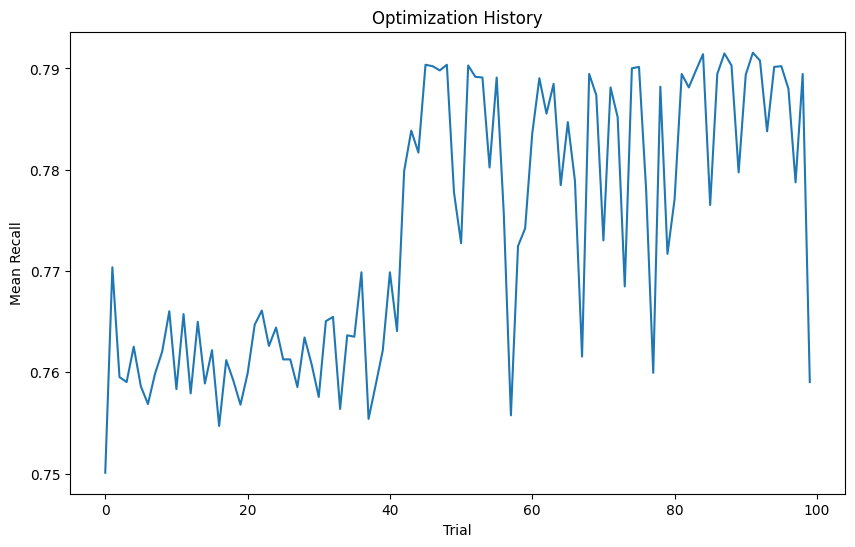

[I 2024-12-30 18:32:12,674] A new study created in memory with name: no-name-9a08e217-2947-4d95-a2cb-9e466f385e43



Optimizing XGBoost hyperparameters for unbalanced dataset...

Starting hyperparameter optimization with 100 trials...
Parameters being optimized:
- max_depth (3-10)
- min_child_weight (1-7)
- gamma (0-1)
- subsample (0.6-1.0)
- colsample_bytree (0.6-1.0)
- learning_rate (0.01-0.3)
- n_estimators (100-500)
- reg_alpha (0-1)
- reg_lambda (0-1)

Optimizing for mean recall score across 5-fold CV
--------------------------------------------------


[I 2024-12-30 18:32:22,581] Trial 0 finished with value: 0.5442283860843805 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.5071142870180146, 'subsample': 0.7666614405864596, 'colsample_bytree': 0.8913689872469215, 'learning_rate': 0.07401749763321755, 'n_estimators': 493, 'reg_alpha': 0.5437088261636437, 'reg_lambda': 0.504243534311343}. Best is trial 0 with value: 0.5442283860843805.


Trial 0: Mean Recall = 0.5442


[I 2024-12-30 18:32:25,094] Trial 1 finished with value: 0.4929030144968628 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.9079422290743697, 'subsample': 0.7638907542478616, 'colsample_bytree': 0.7145498623496045, 'learning_rate': 0.17290644608838168, 'n_estimators': 156, 'reg_alpha': 0.0822877873981217, 'reg_lambda': 0.007261942482671535}. Best is trial 0 with value: 0.5442283860843805.


Trial 1: Mean Recall = 0.4929


[I 2024-12-30 18:32:33,667] Trial 2 finished with value: 0.5415713611798896 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.608580364016261, 'subsample': 0.9158103977102461, 'colsample_bytree': 0.7669344824192492, 'learning_rate': 0.06334715646762859, 'n_estimators': 463, 'reg_alpha': 0.15264799456358036, 'reg_lambda': 0.6965356962918491}. Best is trial 0 with value: 0.5442283860843805.


Trial 2: Mean Recall = 0.5416


[I 2024-12-30 18:32:38,145] Trial 3 finished with value: 0.5041610224797922 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.6977640985811082, 'subsample': 0.6659982144316386, 'colsample_bytree': 0.8280324733904872, 'learning_rate': 0.06309402125579872, 'n_estimators': 263, 'reg_alpha': 0.815371051063306, 'reg_lambda': 0.7879098795802922}. Best is trial 0 with value: 0.5442283860843805.


Trial 3: Mean Recall = 0.5042


[I 2024-12-30 18:32:44,693] Trial 4 finished with value: 0.49772794489676697 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.08148454952876516, 'subsample': 0.7454478233424283, 'colsample_bytree': 0.6348006811751575, 'learning_rate': 0.03951823117242268, 'n_estimators': 405, 'reg_alpha': 0.9408079848536054, 'reg_lambda': 0.47216599209461596}. Best is trial 0 with value: 0.5442283860843805.


Trial 4: Mean Recall = 0.4977


[I 2024-12-30 18:32:53,846] Trial 5 finished with value: 0.548284134600108 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.5345779217220724, 'subsample': 0.7573603016177338, 'colsample_bytree': 0.8166479925482245, 'learning_rate': 0.09110939490087681, 'n_estimators': 437, 'reg_alpha': 0.43583984328929004, 'reg_lambda': 0.3820708165168485}. Best is trial 5 with value: 0.548284134600108.


Trial 5: Mean Recall = 0.5483


[I 2024-12-30 18:32:57,615] Trial 6 finished with value: 0.50681807182681 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.4777764209719624, 'subsample': 0.802884434180654, 'colsample_bytree': 0.8514860996794813, 'learning_rate': 0.05714606486332411, 'n_estimators': 158, 'reg_alpha': 0.18829118789056654, 'reg_lambda': 0.7114106310401602}. Best is trial 5 with value: 0.548284134600108.


Trial 6: Mean Recall = 0.5068


[I 2024-12-30 18:33:03,508] Trial 7 finished with value: 0.5495429736289575 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.42569981708148685, 'subsample': 0.7783396894926419, 'colsample_bytree': 0.7706335326924707, 'learning_rate': 0.13244124341636646, 'n_estimators': 227, 'reg_alpha': 0.09609296946209678, 'reg_lambda': 0.3424996737746969}. Best is trial 7 with value: 0.5495429736289575.


Trial 7: Mean Recall = 0.5495


[I 2024-12-30 18:33:07,568] Trial 8 finished with value: 0.49486054316183636 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.5617492424536857, 'subsample': 0.8121645263012471, 'colsample_bytree': 0.666487790959901, 'learning_rate': 0.042465135944007915, 'n_estimators': 194, 'reg_alpha': 0.9631444384896714, 'reg_lambda': 0.2016573908743956}. Best is trial 7 with value: 0.5495429736289575.


Trial 8: Mean Recall = 0.4949


[I 2024-12-30 18:33:14,609] Trial 9 finished with value: 0.487238629947473 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.1354101117720159, 'subsample': 0.8906744878905005, 'colsample_bytree': 0.8175431624013645, 'learning_rate': 0.014047541450284967, 'n_estimators': 254, 'reg_alpha': 0.4926044378762434, 'reg_lambda': 0.9387325205002865}. Best is trial 7 with value: 0.5495429736289575.


Trial 9: Mean Recall = 0.4872


[I 2024-12-30 18:33:21,217] Trial 10 finished with value: 0.549751712810084 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.31407973358662056, 'subsample': 0.6021118730027439, 'colsample_bytree': 0.9749349006400199, 'learning_rate': 0.23264499309404965, 'n_estimators': 346, 'reg_alpha': 0.00624895102247125, 'reg_lambda': 0.22990572864324352}. Best is trial 10 with value: 0.549751712810084.


Trial 10: Mean Recall = 0.5498


[I 2024-12-30 18:33:27,963] Trial 11 finished with value: 0.54905343869692 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.29464543987795255, 'subsample': 0.6031535456441103, 'colsample_bytree': 0.9951873184098401, 'learning_rate': 0.2973470735131013, 'n_estimators': 354, 'reg_alpha': 0.0022885106491489227, 'reg_lambda': 0.2305375480666783}. Best is trial 10 with value: 0.549751712810084.


Trial 11: Mean Recall = 0.5491


[I 2024-12-30 18:33:33,358] Trial 12 finished with value: 0.5029025989739027 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.3177017740257173, 'subsample': 0.9850873567701399, 'colsample_bytree': 0.9646929538329234, 'learning_rate': 0.15466067411608617, 'n_estimators': 338, 'reg_alpha': 0.27110226858129227, 'reg_lambda': 0.21712274605748272}. Best is trial 10 with value: 0.549751712810084.


Trial 12: Mean Recall = 0.5029


[I 2024-12-30 18:33:37,862] Trial 13 finished with value: 0.5418511792297183 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.2789650730961511, 'subsample': 0.6684124401458114, 'colsample_bytree': 0.9328306489867345, 'learning_rate': 0.2967354830163461, 'n_estimators': 235, 'reg_alpha': 0.3662456451843198, 'reg_lambda': 0.012084583733859566}. Best is trial 10 with value: 0.549751712810084.


Trial 13: Mean Recall = 0.5419


[I 2024-12-30 18:33:43,274] Trial 14 finished with value: 0.5298936016796905 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.37374321998627846, 'subsample': 0.6844160964731419, 'colsample_bytree': 0.7402924553600917, 'learning_rate': 0.14718779863291412, 'n_estimators': 316, 'reg_alpha': 0.003268763744531629, 'reg_lambda': 0.34867046531124346}. Best is trial 10 with value: 0.549751712810084.


Trial 14: Mean Recall = 0.5299


[I 2024-12-30 18:33:50,273] Trial 15 finished with value: 0.5377956262542072 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.7791967674505812, 'subsample': 0.8727469443341975, 'colsample_bytree': 0.9086524314418485, 'learning_rate': 0.11849807762026097, 'n_estimators': 379, 'reg_alpha': 0.6920730800861691, 'reg_lambda': 0.5702877381948366}. Best is trial 10 with value: 0.549751712810084.


Trial 15: Mean Recall = 0.5378


[I 2024-12-30 18:33:53,049] Trial 16 finished with value: 0.5373760947196808 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.16459904050572027, 'subsample': 0.6384575345579173, 'colsample_bytree': 0.6924692414929627, 'learning_rate': 0.21468142506675203, 'n_estimators': 102, 'reg_alpha': 0.29867930938997284, 'reg_lambda': 0.3291033949132451}. Best is trial 10 with value: 0.549751712810084.


Trial 16: Mean Recall = 0.5374


[I 2024-12-30 18:33:58,008] Trial 17 finished with value: 0.43031987935168636 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.026159603573951862, 'subsample': 0.7113302371963242, 'colsample_bytree': 0.8740081908969403, 'learning_rate': 0.011129936559624184, 'n_estimators': 294, 'reg_alpha': 0.22718972713445618, 'reg_lambda': 0.09695025354185721}. Best is trial 10 with value: 0.549751712810084.


Trial 17: Mean Recall = 0.4303


[I 2024-12-30 18:34:02,650] Trial 18 finished with value: 0.4994061932475075 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.4236183898480856, 'subsample': 0.8371653920919462, 'colsample_bytree': 0.7656320038518762, 'learning_rate': 0.027881614001542064, 'n_estimators': 204, 'reg_alpha': 0.09230900956686783, 'reg_lambda': 0.13229433902350413}. Best is trial 10 with value: 0.549751712810084.


Trial 18: Mean Recall = 0.4994


[I 2024-12-30 18:34:09,267] Trial 19 finished with value: 0.5428303713064286 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.21449688185284244, 'subsample': 0.6004434123729263, 'colsample_bytree': 0.6095346059715698, 'learning_rate': 0.10993537588725927, 'n_estimators': 294, 'reg_alpha': 0.1020391414922327, 'reg_lambda': 0.3149004784073275}. Best is trial 10 with value: 0.549751712810084.


Trial 19: Mean Recall = 0.5428


[I 2024-12-30 18:34:15,460] Trial 20 finished with value: 0.5301032452343183 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.6837352074826004, 'subsample': 0.9736483558156623, 'colsample_bytree': 0.7793338267056407, 'learning_rate': 0.21742344333414795, 'n_estimators': 394, 'reg_alpha': 0.6411843947796845, 'reg_lambda': 0.4360695861378986}. Best is trial 10 with value: 0.549751712810084.


Trial 20: Mean Recall = 0.5301


[I 2024-12-30 18:34:22,093] Trial 21 finished with value: 0.5491933966068884 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.27686581689743783, 'subsample': 0.6013714374941713, 'colsample_bytree': 0.9963150486377053, 'learning_rate': 0.2976568392834983, 'n_estimators': 351, 'reg_alpha': 0.007925330242837637, 'reg_lambda': 0.2364756570130025}. Best is trial 10 with value: 0.549751712810084.


Trial 21: Mean Recall = 0.5492


[I 2024-12-30 18:34:28,583] Trial 22 finished with value: 0.5458363132847579 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3716783391012113, 'subsample': 0.6293895527063984, 'colsample_bytree': 0.9981023971222346, 'learning_rate': 0.2068267768744112, 'n_estimators': 342, 'reg_alpha': 0.07853535660580638, 'reg_lambda': 0.2559037438328746}. Best is trial 10 with value: 0.549751712810084.


Trial 22: Mean Recall = 0.5458


[I 2024-12-30 18:34:33,298] Trial 23 finished with value: 0.5275163459399741 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.22487169341811603, 'subsample': 0.7198945698391985, 'colsample_bytree': 0.9457801704610942, 'learning_rate': 0.2513503364636862, 'n_estimators': 280, 'reg_alpha': 0.0021368317650243933, 'reg_lambda': 0.12077236615806575}. Best is trial 10 with value: 0.549751712810084.


Trial 23: Mean Recall = 0.5275


[I 2024-12-30 18:34:41,026] Trial 24 finished with value: 0.5423407386042829 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.42054321838505576, 'subsample': 0.6386414227081225, 'colsample_bytree': 0.9537494041573303, 'learning_rate': 0.12060691645635631, 'n_estimators': 429, 'reg_alpha': 0.346293454775282, 'reg_lambda': 0.5679155962336356}. Best is trial 10 with value: 0.549751712810084.


Trial 24: Mean Recall = 0.5423


[I 2024-12-30 18:34:47,121] Trial 25 finished with value: 0.537445291513799 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.24659555287092383, 'subsample': 0.6893991740549563, 'colsample_bytree': 0.9143579461663361, 'learning_rate': 0.16580162650275845, 'n_estimators': 363, 'reg_alpha': 0.16535620234497345, 'reg_lambda': 0.27477848832980056}. Best is trial 10 with value: 0.549751712810084.


Trial 25: Mean Recall = 0.5374


[I 2024-12-30 18:34:53,645] Trial 26 finished with value: 0.5426200922460971 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.3535394919288681, 'subsample': 0.6297338592574035, 'colsample_bytree': 0.9764859799693462, 'learning_rate': 0.09303034986606608, 'n_estimators': 324, 'reg_alpha': 0.24426250749020212, 'reg_lambda': 0.15709698670633754}. Best is trial 10 with value: 0.549751712810084.


Trial 26: Mean Recall = 0.5426


[I 2024-12-30 18:34:57,568] Trial 27 finished with value: 0.5229709158370466 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.44291046727002803, 'subsample': 0.9403456673533468, 'colsample_bytree': 0.8754862836492014, 'learning_rate': 0.24583891212401376, 'n_estimators': 225, 'reg_alpha': 0.1293960244425602, 'reg_lambda': 0.403981095214961}. Best is trial 10 with value: 0.549751712810084.


Trial 27: Mean Recall = 0.5230


[I 2024-12-30 18:35:01,528] Trial 28 finished with value: 0.5468156031315765 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0023237772549719593, 'subsample': 0.8557083050100771, 'colsample_bytree': 0.7242854489723193, 'learning_rate': 0.19173371424529034, 'n_estimators': 176, 'reg_alpha': 0.0590921501338044, 'reg_lambda': 0.06791553680728418}. Best is trial 10 with value: 0.549751712810084.


Trial 28: Mean Recall = 0.5468


[I 2024-12-30 18:35:04,058] Trial 29 finished with value: 0.43975975440148807 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.12874346461753364, 'subsample': 0.7149363383741496, 'colsample_bytree': 0.855922056778382, 'learning_rate': 0.020691870755214586, 'n_estimators': 118, 'reg_alpha': 0.5847074445438398, 'reg_lambda': 0.5450036647850129}. Best is trial 10 with value: 0.549751712810084.


Trial 29: Mean Recall = 0.4398


[I 2024-12-30 18:35:13,450] Trial 30 finished with value: 0.5396831270791425 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.5127200146997576, 'subsample': 0.7853611386643203, 'colsample_bytree': 0.9067861014087697, 'learning_rate': 0.08809116177510597, 'n_estimators': 492, 'reg_alpha': 0.38836612174109386, 'reg_lambda': 0.4944643167233326}. Best is trial 10 with value: 0.549751712810084.


Trial 30: Mean Recall = 0.5397


[I 2024-12-30 18:35:20,346] Trial 31 finished with value: 0.5527591946676182 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.3213325828151116, 'subsample': 0.611419081258192, 'colsample_bytree': 0.9989760974924984, 'learning_rate': 0.29932775923403776, 'n_estimators': 358, 'reg_alpha': 0.0073108826325587704, 'reg_lambda': 0.21515863265287397}. Best is trial 31 with value: 0.5527591946676182.


Trial 31: Mean Recall = 0.5528


[I 2024-12-30 18:35:26,938] Trial 32 finished with value: 0.5417108302393168 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.3205220305120578, 'subsample': 0.6134395199157016, 'colsample_bytree': 0.9956020587856738, 'learning_rate': 0.2991904549622465, 'n_estimators': 378, 'reg_alpha': 0.059166956109763934, 'reg_lambda': 0.18035034424862595}. Best is trial 31 with value: 0.5527591946676182.


Trial 32: Mean Recall = 0.5417


[I 2024-12-30 18:35:34,375] Trial 33 finished with value: 0.5385638548798284 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.3929862254555708, 'subsample': 0.6544720795235233, 'colsample_bytree': 0.9807242005786234, 'learning_rate': 0.13440225165549952, 'n_estimators': 414, 'reg_alpha': 0.17700908329276593, 'reg_lambda': 0.2971712194768745}. Best is trial 31 with value: 0.5527591946676182.


Trial 33: Mean Recall = 0.5386


[I 2024-12-30 18:35:41,693] Trial 34 finished with value: 0.554157527198422 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.1892555516168981, 'subsample': 0.649456502470628, 'colsample_bytree': 0.9297625696712275, 'learning_rate': 0.1768579511320393, 'n_estimators': 311, 'reg_alpha': 0.04574049541793898, 'reg_lambda': 0.37275477320252115}. Best is trial 34 with value: 0.554157527198422.


Trial 34: Mean Recall = 0.5542


[I 2024-12-30 18:35:49,327] Trial 35 finished with value: 0.5538079501763529 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.186113774678151, 'subsample': 0.6819484738073972, 'colsample_bytree': 0.930924609321616, 'learning_rate': 0.17518600738512613, 'n_estimators': 305, 'reg_alpha': 0.13812560838634813, 'reg_lambda': 0.3836843766711349}. Best is trial 34 with value: 0.554157527198422.


Trial 35: Mean Recall = 0.5538


[I 2024-12-30 18:35:56,891] Trial 36 finished with value: 0.5482140823175427 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.18835945975683355, 'subsample': 0.6599499193752896, 'colsample_bytree': 0.9344180440239364, 'learning_rate': 0.17529969501973386, 'n_estimators': 308, 'reg_alpha': 0.20671475333810005, 'reg_lambda': 0.4391665341295922}. Best is trial 34 with value: 0.554157527198422.


Trial 36: Mean Recall = 0.5482


[I 2024-12-30 18:36:03,147] Trial 37 finished with value: 0.539193616589632 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.08201077553521158, 'subsample': 0.6911245368918083, 'colsample_bytree': 0.927486526204618, 'learning_rate': 0.07464830083778638, 'n_estimators': 280, 'reg_alpha': 0.15599552463183353, 'reg_lambda': 0.3798505858415123}. Best is trial 34 with value: 0.554157527198422.


Trial 37: Mean Recall = 0.5392


[I 2024-12-30 18:36:11,299] Trial 38 finished with value: 0.5569548766507871 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.10775007818481452, 'subsample': 0.7331153210259359, 'colsample_bytree': 0.8881629271091166, 'learning_rate': 0.24326682109552722, 'n_estimators': 325, 'reg_alpha': 0.8039949178316368, 'reg_lambda': 0.6032928827876697}. Best is trial 38 with value: 0.5569548766507871.


Trial 38: Mean Recall = 0.5570


[I 2024-12-30 18:36:17,571] Trial 39 finished with value: 0.5510808241042425 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.06670024431503124, 'subsample': 0.7454691917926847, 'colsample_bytree': 0.8855994450386346, 'learning_rate': 0.1812986144646284, 'n_estimators': 261, 'reg_alpha': 0.7483484415791682, 'reg_lambda': 0.6652813351833268}. Best is trial 38 with value: 0.5569548766507871.


Trial 39: Mean Recall = 0.5511


[I 2024-12-30 18:36:29,346] Trial 40 finished with value: 0.556465488373912 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.11654341585828257, 'subsample': 0.7221460140898643, 'colsample_bytree': 0.8973799396811569, 'learning_rate': 0.24937863006585248, 'n_estimators': 454, 'reg_alpha': 0.819197569778484, 'reg_lambda': 0.6273512354028982}. Best is trial 38 with value: 0.5569548766507871.


Trial 40: Mean Recall = 0.5565


[I 2024-12-30 18:36:40,696] Trial 41 finished with value: 0.5559755868039684 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.11030562883732567, 'subsample': 0.7380345470513318, 'colsample_bytree': 0.8404213479875381, 'learning_rate': 0.25689914226971194, 'n_estimators': 468, 'reg_alpha': 0.8755738558262824, 'reg_lambda': 0.6183477267168693}. Best is trial 38 with value: 0.5569548766507871.


Trial 41: Mean Recall = 0.5560


[I 2024-12-30 18:36:52,104] Trial 42 finished with value: 0.556115202518558 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.11320960999996299, 'subsample': 0.7321890454459234, 'colsample_bytree': 0.8410738624858773, 'learning_rate': 0.2434305594148027, 'n_estimators': 459, 'reg_alpha': 0.8870539418204053, 'reg_lambda': 0.646994103043685}. Best is trial 38 with value: 0.5569548766507871.


Trial 42: Mean Recall = 0.5561


[I 2024-12-30 18:37:02,586] Trial 43 finished with value: 0.5585630727189623 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.11119451466068629, 'subsample': 0.7355647138419195, 'colsample_bytree': 0.8402162393029995, 'learning_rate': 0.24702712815330186, 'n_estimators': 463, 'reg_alpha': 0.8689200633279537, 'reg_lambda': 0.6459699807327848}. Best is trial 43 with value: 0.5585630727189623.


Trial 43: Mean Recall = 0.5586


[I 2024-12-30 18:37:13,050] Trial 44 finished with value: 0.5610798219606329 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.10648224733630389, 'subsample': 0.7391173839559018, 'colsample_bytree': 0.8393630593446548, 'learning_rate': 0.24149160651874557, 'n_estimators': 457, 'reg_alpha': 0.8826861413949294, 'reg_lambda': 0.6416656701493928}. Best is trial 44 with value: 0.5610798219606329.


Trial 44: Mean Recall = 0.5611


[I 2024-12-30 18:37:22,883] Trial 45 finished with value: 0.5364666127301569 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.060406719148712415, 'subsample': 0.7683384056804649, 'colsample_bytree': 0.7940467023777351, 'learning_rate': 0.04440723855230675, 'n_estimators': 459, 'reg_alpha': 0.8979579606964623, 'reg_lambda': 0.7816147552222547}. Best is trial 44 with value: 0.5610798219606329.


Trial 45: Mean Recall = 0.5365


[I 2024-12-30 18:37:32,132] Trial 46 finished with value: 0.5524096176455491 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.9958987627042679, 'subsample': 0.7315158792467984, 'colsample_bytree': 0.82567281640957, 'learning_rate': 0.24250072721188123, 'n_estimators': 483, 'reg_alpha': 0.9934134732403884, 'reg_lambda': 0.762407004238983}. Best is trial 44 with value: 0.5610798219606329.


Trial 46: Mean Recall = 0.5524


[I 2024-12-30 18:37:42,853] Trial 47 finished with value: 0.555206478247373 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.044115113099119016, 'subsample': 0.82125379345823, 'colsample_bytree': 0.8465397958767866, 'learning_rate': 0.14612323200688188, 'n_estimators': 455, 'reg_alpha': 0.8159649356906082, 'reg_lambda': 0.7029073595561968}. Best is trial 44 with value: 0.5610798219606329.


Trial 47: Mean Recall = 0.5552


[I 2024-12-30 18:37:52,109] Trial 48 finished with value: 0.5530388905048115 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.13707120189493685, 'subsample': 0.7577730171585497, 'colsample_bytree': 0.8066580533791202, 'learning_rate': 0.21465347290273246, 'n_estimators': 435, 'reg_alpha': 0.8016599687653838, 'reg_lambda': 0.8317994757756986}. Best is trial 44 with value: 0.5610798219606329.


Trial 48: Mean Recall = 0.5530


[I 2024-12-30 18:38:04,754] Trial 49 finished with value: 0.5556961842771001 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.10172804148485302, 'subsample': 0.7913299928708754, 'colsample_bytree': 0.866829536195247, 'learning_rate': 0.2639383553654222, 'n_estimators': 418, 'reg_alpha': 0.914805286561925, 'reg_lambda': 0.6606923495468806}. Best is trial 44 with value: 0.5610798219606329.


Trial 49: Mean Recall = 0.5557


[I 2024-12-30 18:38:16,242] Trial 50 finished with value: 0.5536676256284785 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.14111814908826312, 'subsample': 0.7721551378612328, 'colsample_bytree': 0.8950167675584011, 'learning_rate': 0.20545814604509796, 'n_estimators': 475, 'reg_alpha': 0.8645530811952636, 'reg_lambda': 0.8681966970523693}. Best is trial 44 with value: 0.5610798219606329.


Trial 50: Mean Recall = 0.5537


[I 2024-12-30 18:38:29,391] Trial 51 finished with value: 0.5550664958948776 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.09816288677530975, 'subsample': 0.7401837425603043, 'colsample_bytree': 0.8314059349395283, 'learning_rate': 0.24837803375823458, 'n_estimators': 499, 'reg_alpha': 0.8549859546629419, 'reg_lambda': 0.6197896650497716}. Best is trial 44 with value: 0.5610798219606329.


Trial 51: Mean Recall = 0.5551


[I 2024-12-30 18:38:40,552] Trial 52 finished with value: 0.5559759045568203 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.014636995180590542, 'subsample': 0.7041827786674087, 'colsample_bytree': 0.8427035803145488, 'learning_rate': 0.25970056457858526, 'n_estimators': 448, 'reg_alpha': 0.7560817487885284, 'reg_lambda': 0.6234505389916536}. Best is trial 44 with value: 0.5610798219606329.


Trial 52: Mean Recall = 0.5560


[I 2024-12-30 18:38:50,289] Trial 53 finished with value: 0.5545072019905994 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.023344577019126636, 'subsample': 0.7028544628143444, 'colsample_bytree': 0.8597244694542716, 'learning_rate': 0.15763075134354596, 'n_estimators': 448, 'reg_alpha': 0.7193270740041813, 'reg_lambda': 0.6182904199696612}. Best is trial 44 with value: 0.5610798219606329.


Trial 53: Mean Recall = 0.5545


[I 2024-12-30 18:39:01,039] Trial 54 finished with value: 0.55443751634594 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.007260370789896964, 'subsample': 0.7544654513149064, 'colsample_bytree': 0.8063185336246704, 'learning_rate': 0.1980833912495291, 'n_estimators': 443, 'reg_alpha': 0.7889662276716337, 'reg_lambda': 0.7212583087799217}. Best is trial 44 with value: 0.5610798219606329.


Trial 54: Mean Recall = 0.5544


[I 2024-12-30 18:39:10,960] Trial 55 finished with value: 0.5575836851020353 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.15517590306528461, 'subsample': 0.7240709103199622, 'colsample_bytree': 0.8822356524151649, 'learning_rate': 0.22784494228364002, 'n_estimators': 402, 'reg_alpha': 0.9584787954434459, 'reg_lambda': 0.5376575193800011}. Best is trial 44 with value: 0.5610798219606329.


Trial 55: Mean Recall = 0.5576


[I 2024-12-30 18:39:21,446] Trial 56 finished with value: 0.5524092510076433 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.16126266774266287, 'subsample': 0.8031138188928126, 'colsample_bytree': 0.8865742711404493, 'learning_rate': 0.1362912360319974, 'n_estimators': 399, 'reg_alpha': 0.941119057650091, 'reg_lambda': 0.5486650208366953}. Best is trial 44 with value: 0.5610798219606329.


Trial 56: Mean Recall = 0.5524


[I 2024-12-30 18:39:31,054] Trial 57 finished with value: 0.5577938419497315 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.2605645637647977, 'subsample': 0.7266263211870921, 'colsample_bytree': 0.8986330335913163, 'learning_rate': 0.22279604291028085, 'n_estimators': 421, 'reg_alpha': 0.9919261162566501, 'reg_lambda': 0.5192745885874412}. Best is trial 44 with value: 0.5610798219606329.


Trial 57: Mean Recall = 0.5578


[I 2024-12-30 18:39:41,085] Trial 58 finished with value: 0.5574440938299728 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.24641822497739774, 'subsample': 0.7283589602025812, 'colsample_bytree': 0.892656146443645, 'learning_rate': 0.2213016419378186, 'n_estimators': 385, 'reg_alpha': 0.990212133938415, 'reg_lambda': 0.5343949385578592}. Best is trial 44 with value: 0.5610798219606329.


Trial 58: Mean Recall = 0.5574


[I 2024-12-30 18:39:49,923] Trial 59 finished with value: 0.5504517223426696 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.24539151043900734, 'subsample': 0.7514245058345494, 'colsample_bytree': 0.8799384320131173, 'learning_rate': 0.10831685952431476, 'n_estimators': 378, 'reg_alpha': 0.9706417315507586, 'reg_lambda': 0.5162348820589749}. Best is trial 44 with value: 0.5610798219606329.


Trial 59: Mean Recall = 0.5505


[I 2024-12-30 18:39:59,240] Trial 60 finished with value: 0.5545071042204912 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.5911424850385446, 'subsample': 0.6777987352609138, 'colsample_bytree': 0.9012805074434894, 'learning_rate': 0.21740052602979434, 'n_estimators': 422, 'reg_alpha': 0.9975223319841525, 'reg_lambda': 0.4691578460067329}. Best is trial 44 with value: 0.5610798219606329.


Trial 60: Mean Recall = 0.5545


[I 2024-12-30 18:40:08,332] Trial 61 finished with value: 0.5560453457762091 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.22209995369289362, 'subsample': 0.7260476145178204, 'colsample_bytree': 0.9172427049168077, 'learning_rate': 0.27358453970970187, 'n_estimators': 384, 'reg_alpha': 0.9297075981357028, 'reg_lambda': 0.5859291137558041}. Best is trial 44 with value: 0.5610798219606329.


Trial 61: Mean Recall = 0.5560


[I 2024-12-30 18:40:17,306] Trial 62 finished with value: 0.5545070064503829 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.24749812127171522, 'subsample': 0.6955430745989172, 'colsample_bytree': 0.8661645031807308, 'learning_rate': 0.22805761056459548, 'n_estimators': 406, 'reg_alpha': 0.8466041442489943, 'reg_lambda': 0.5153521343814176}. Best is trial 44 with value: 0.5610798219606329.


Trial 62: Mean Recall = 0.5545


[I 2024-12-30 18:40:27,511] Trial 63 finished with value: 0.552339296495186 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.16263403400962356, 'subsample': 0.7177950412427209, 'colsample_bytree': 0.8950725294208752, 'learning_rate': 0.19798002503522938, 'n_estimators': 430, 'reg_alpha': 0.9496068937084851, 'reg_lambda': 0.7367430305710356}. Best is trial 44 with value: 0.5610798219606329.


Trial 63: Mean Recall = 0.5523


[I 2024-12-30 18:40:39,396] Trial 64 finished with value: 0.553458128729013 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.2788953579430874, 'subsample': 0.766054158249249, 'colsample_bytree': 0.9517409381250022, 'learning_rate': 0.15422067370261075, 'n_estimators': 482, 'reg_alpha': 0.8347694224313441, 'reg_lambda': 0.5931187952681917}. Best is trial 44 with value: 0.5610798219606329.


Trial 64: Mean Recall = 0.5535


[I 2024-12-30 18:40:51,859] Trial 65 finished with value: 0.553808023503934 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.05052820429385135, 'subsample': 0.6710101001022829, 'colsample_bytree': 0.8707994830818577, 'learning_rate': 0.22364560151614568, 'n_estimators': 437, 'reg_alpha': 0.970476414634099, 'reg_lambda': 0.6884153640676716}. Best is trial 44 with value: 0.5610798219606329.


Trial 65: Mean Recall = 0.5538


[I 2024-12-30 18:41:00,994] Trial 66 finished with value: 0.5175864959926477 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.2029786233675021, 'subsample': 0.7824980250166471, 'colsample_bytree': 0.9145866970936505, 'learning_rate': 0.026621243317556578, 'n_estimators': 393, 'reg_alpha': 0.9068706948738519, 'reg_lambda': 0.5335730623403303}. Best is trial 44 with value: 0.5610798219606329.


Trial 66: Mean Recall = 0.5176


[I 2024-12-30 18:41:09,880] Trial 67 finished with value: 0.5561853036861775 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.8035091766768818, 'subsample': 0.7090301553402342, 'colsample_bytree': 0.823760164449228, 'learning_rate': 0.2739857031474557, 'n_estimators': 367, 'reg_alpha': 0.6495459940306361, 'reg_lambda': 0.47557815088143696}. Best is trial 44 with value: 0.5610798219606329.


Trial 67: Mean Recall = 0.5562


[I 2024-12-30 18:41:18,659] Trial 68 finished with value: 0.5495423381232539 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.16600929601442438, 'subsample': 0.7261941468570524, 'colsample_bytree': 0.8566904027384561, 'learning_rate': 0.1944595917288224, 'n_estimators': 407, 'reg_alpha': 0.5131872003930331, 'reg_lambda': 0.5724766548158522}. Best is trial 44 with value: 0.5610798219606329.


Trial 68: Mean Recall = 0.5495


[I 2024-12-30 18:41:26,884] Trial 69 finished with value: 0.5547171877406061 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.14399626162717857, 'subsample': 0.7434004445781107, 'colsample_bytree': 0.7896371504049775, 'learning_rate': 0.2307512747751616, 'n_estimators': 323, 'reg_alpha': 0.783047734750384, 'reg_lambda': 0.678367982124071}. Best is trial 44 with value: 0.5610798219606329.


Trial 69: Mean Recall = 0.5547


[I 2024-12-30 18:41:38,715] Trial 70 finished with value: 0.5530389638323927 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.08305680299895035, 'subsample': 0.7188715996683293, 'colsample_bytree': 0.7520135321600904, 'learning_rate': 0.16377891224971716, 'n_estimators': 470, 'reg_alpha': 0.9290924229363591, 'reg_lambda': 0.425765813717613}. Best is trial 44 with value: 0.5610798219606329.


Trial 70: Mean Recall = 0.5530


[I 2024-12-30 18:41:47,683] Trial 71 finished with value: 0.5574441182725 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.7853207144432445, 'subsample': 0.7005032324470435, 'colsample_bytree': 0.8153243338128816, 'learning_rate': 0.27963819523964, 'n_estimators': 376, 'reg_alpha': 0.6621109409843845, 'reg_lambda': 0.4822099371462966}. Best is trial 44 with value: 0.5610798219606329.


Trial 71: Mean Recall = 0.5574


[I 2024-12-30 18:41:56,090] Trial 72 finished with value: 0.5487730829114961 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.95843798212266, 'subsample': 0.7008268706450612, 'colsample_bytree': 0.8127524391196057, 'learning_rate': 0.2769977968010793, 'n_estimators': 368, 'reg_alpha': 0.6446146215673494, 'reg_lambda': 0.47848443127008417}. Best is trial 44 with value: 0.5610798219606329.


Trial 72: Mean Recall = 0.5488


[I 2024-12-30 18:42:04,532] Trial 73 finished with value: 0.552828929197332 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.659992111121159, 'subsample': 0.7613909930919289, 'colsample_bytree': 0.8885914184328534, 'learning_rate': 0.18477249029997772, 'n_estimators': 339, 'reg_alpha': 0.8283547634455489, 'reg_lambda': 0.5367180037743474}. Best is trial 44 with value: 0.5610798219606329.


Trial 73: Mean Recall = 0.5528


[I 2024-12-30 18:42:13,357] Trial 74 finished with value: 0.5528994947729655 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.8385382367938632, 'subsample': 0.7107208332084491, 'colsample_bytree': 0.8769804689209105, 'learning_rate': 0.22718489186521254, 'n_estimators': 417, 'reg_alpha': 0.6781152091985474, 'reg_lambda': 0.5982341144246746}. Best is trial 44 with value: 0.5610798219606329.


Trial 74: Mean Recall = 0.5529


[I 2024-12-30 18:42:22,102] Trial 75 finished with value: 0.5498919640303772 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.7310100363248666, 'subsample': 0.6812077474437426, 'colsample_bytree': 0.8342603243421504, 'learning_rate': 0.27415108295525564, 'n_estimators': 395, 'reg_alpha': 0.5633886951748717, 'reg_lambda': 0.6471349798641444}. Best is trial 44 with value: 0.5610798219606329.


Trial 75: Mean Recall = 0.5499


[I 2024-12-30 18:42:32,047] Trial 76 finished with value: 0.5560460546094939 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.4856614454776207, 'subsample': 0.7315803853279765, 'colsample_bytree': 0.8543085754635552, 'learning_rate': 0.20425083476915076, 'n_estimators': 427, 'reg_alpha': 0.7609369740136593, 'reg_lambda': 0.49740799375733513}. Best is trial 44 with value: 0.5610798219606329.


Trial 76: Mean Recall = 0.5560


[I 2024-12-30 18:42:41,571] Trial 77 finished with value: 0.5591921500380082 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.24411890926582813, 'subsample': 0.6922078479137618, 'colsample_bytree': 0.7764177938101506, 'learning_rate': 0.28935443615098766, 'n_estimators': 384, 'reg_alpha': 0.9650403431005815, 'reg_lambda': 0.4518151442526878}. Best is trial 44 with value: 0.5610798219606329.


Trial 77: Mean Recall = 0.5592


[I 2024-12-30 18:42:49,789] Trial 78 finished with value: 0.5297535704421409 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.25167006298029254, 'subsample': 0.6682408636864239, 'colsample_bytree': 0.7817453215172951, 'learning_rate': 0.05491131231748472, 'n_estimators': 353, 'reg_alpha': 0.9743370270629704, 'reg_lambda': 0.43126146211426986}. Best is trial 44 with value: 0.5610798219606329.


Trial 78: Mean Recall = 0.5298


[I 2024-12-30 18:42:58,745] Trial 79 finished with value: 0.5561853036861775 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.3505547423792385, 'subsample': 0.7450839097185399, 'colsample_bytree': 0.6969423372009851, 'learning_rate': 0.2950977189327336, 'n_estimators': 388, 'reg_alpha': 0.8750474262565977, 'reg_lambda': 0.557422410318113}. Best is trial 44 with value: 0.5610798219606329.


Trial 79: Mean Recall = 0.5562


[I 2024-12-30 18:43:04,505] Trial 80 finished with value: 0.5103842854105001 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.21200601446170445, 'subsample': 0.6980047776252343, 'colsample_bytree': 0.7562161991902926, 'learning_rate': 0.18560992493249917, 'n_estimators': 372, 'reg_alpha': 0.9516198209518753, 'reg_lambda': 0.4613905977617857}. Best is trial 44 with value: 0.5610798219606329.


Trial 80: Mean Recall = 0.5104


[I 2024-12-30 18:43:13,103] Trial 81 finished with value: 0.555696159834573 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.17904349660457153, 'subsample': 0.7204078975588685, 'colsample_bytree': 0.9062634182769347, 'learning_rate': 0.2352699806222523, 'n_estimators': 331, 'reg_alpha': 0.9078535959779453, 'reg_lambda': 0.5989434575862557}. Best is trial 44 with value: 0.5610798219606329.


Trial 81: Mean Recall = 0.5557


[I 2024-12-30 18:43:23,107] Trial 82 finished with value: 0.5571634936192783 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.29596698248077385, 'subsample': 0.688146292482535, 'colsample_bytree': 0.9242636113803522, 'learning_rate': 0.25405390923294374, 'n_estimators': 410, 'reg_alpha': 0.9913626044316427, 'reg_lambda': 0.5223624417982088}. Best is trial 44 with value: 0.5610798219606329.


Trial 82: Mean Recall = 0.5572


[I 2024-12-30 18:43:32,911] Trial 83 finished with value: 0.5545075930710324 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.29658983719393894, 'subsample': 0.6925720896401161, 'colsample_bytree': 0.9417007056227765, 'learning_rate': 0.27042679795090296, 'n_estimators': 414, 'reg_alpha': 0.9824984437551068, 'reg_lambda': 0.5154597249753489}. Best is trial 44 with value: 0.5610798219606329.


Trial 83: Mean Recall = 0.5545


[I 2024-12-30 18:43:43,143] Trial 84 finished with value: 0.5542277750212039 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.23470558165513583, 'subsample': 0.6503996767669469, 'colsample_bytree': 0.9214672140376748, 'learning_rate': 0.29819739021848446, 'n_estimators': 407, 'reg_alpha': 0.9340667504762847, 'reg_lambda': 0.44788551137883764}. Best is trial 44 with value: 0.5610798219606329.


Trial 84: Mean Recall = 0.5542


[I 2024-12-30 18:43:51,813] Trial 85 finished with value: 0.501713225606969 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.27363765529055906, 'subsample': 0.7083788945432035, 'colsample_bytree': 0.7728724394022115, 'learning_rate': 0.015366093059255657, 'n_estimators': 347, 'reg_alpha': 0.8879589033571861, 'reg_lambda': 0.4090749324124949}. Best is trial 44 with value: 0.5610798219606329.


Trial 85: Mean Recall = 0.5017


[I 2024-12-30 18:44:01,414] Trial 86 finished with value: 0.5547874844484422 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.4536382610107632, 'subsample': 0.6867560193343344, 'colsample_bytree': 0.9666949608833239, 'learning_rate': 0.21491846777455184, 'n_estimators': 400, 'reg_alpha': 0.9996483702525594, 'reg_lambda': 0.4970938841473044}. Best is trial 44 with value: 0.5610798219606329.


Trial 86: Mean Recall = 0.5548


[I 2024-12-30 18:44:10,391] Trial 87 finished with value: 0.5533887852797326 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.3449976340610038, 'subsample': 0.7492696275279821, 'colsample_bytree': 0.8175222905072822, 'learning_rate': 0.17052646902920812, 'n_estimators': 385, 'reg_alpha': 0.9481462247740837, 'reg_lambda': 0.5709316958787894}. Best is trial 44 with value: 0.5610798219606329.


Trial 87: Mean Recall = 0.5534


[I 2024-12-30 18:44:20,712] Trial 88 finished with value: 0.5561852059160692 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.2001635216073922, 'subsample': 0.7740288737944149, 'colsample_bytree': 0.8637244945082571, 'learning_rate': 0.24719780462460345, 'n_estimators': 445, 'reg_alpha': 0.6112141336571882, 'reg_lambda': 0.3612176112951092}. Best is trial 44 with value: 0.5610798219606329.


Trial 88: Mean Recall = 0.5562


[I 2024-12-30 18:44:29,508] Trial 89 finished with value: 0.5532489006973453 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.5417805054669309, 'subsample': 0.7380750323212188, 'colsample_bytree': 0.7958129823900912, 'learning_rate': 0.14484502826865786, 'n_estimators': 360, 'reg_alpha': 0.9122765499851612, 'reg_lambda': 0.5447699269256733}. Best is trial 44 with value: 0.5610798219606329.


Trial 89: Mean Recall = 0.5532


[I 2024-12-30 18:44:39,193] Trial 90 finished with value: 0.5451374036658903 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.3107366162267346, 'subsample': 0.6607133531520963, 'colsample_bytree': 0.881326620634816, 'learning_rate': 0.06808694084994577, 'n_estimators': 374, 'reg_alpha': 0.7264930396577517, 'reg_lambda': 0.40729624053337155}. Best is trial 44 with value: 0.5610798219606329.


Trial 90: Mean Recall = 0.5451


[I 2024-12-30 18:44:50,926] Trial 91 finished with value: 0.5552764572023572 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.11452919164826078, 'subsample': 0.726516153526771, 'colsample_bytree': 0.8992972495757078, 'learning_rate': 0.2387885239556533, 'n_estimators': 458, 'reg_alpha': 0.8499626678784639, 'reg_lambda': 0.6311067725501195}. Best is trial 44 with value: 0.5610798219606329.


Trial 91: Mean Recall = 0.5553


[I 2024-12-30 18:45:01,837] Trial 92 finished with value: 0.5548570478804662 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.1252109864936798, 'subsample': 0.676597409487361, 'colsample_bytree': 0.9071704924882993, 'learning_rate': 0.2563730909751891, 'n_estimators': 439, 'reg_alpha': 0.4340453817241431, 'reg_lambda': 0.999466354827006}. Best is trial 44 with value: 0.5610798219606329.


Trial 92: Mean Recall = 0.5549


[I 2024-12-30 18:45:11,492] Trial 93 finished with value: 0.5533187574396942 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.39840577026859003, 'subsample': 0.7136854123711779, 'colsample_bytree': 0.8489333064190943, 'learning_rate': 0.2056990648630495, 'n_estimators': 425, 'reg_alpha': 0.9658239439808912, 'reg_lambda': 0.5259409928481386}. Best is trial 44 with value: 0.5610798219606329.


Trial 93: Mean Recall = 0.5533


[I 2024-12-30 18:45:23,802] Trial 94 finished with value: 0.5564652928336955 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.07622551919744114, 'subsample': 0.7337406344556366, 'colsample_bytree': 0.9419446773643788, 'learning_rate': 0.2791209109758111, 'n_estimators': 484, 'reg_alpha': 0.8140972181370878, 'reg_lambda': 0.576940161807216}. Best is trial 44 with value: 0.5610798219606329.


Trial 94: Mean Recall = 0.5565


[I 2024-12-30 18:45:36,179] Trial 95 finished with value: 0.5519898416857522 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.04461325741055848, 'subsample': 0.6897052313180068, 'colsample_bytree': 0.8946707668280557, 'learning_rate': 0.2588361870602293, 'n_estimators': 477, 'reg_alpha': 0.9024563359068579, 'reg_lambda': 0.647949399326897}. Best is trial 44 with value: 0.5610798219606329.


Trial 95: Mean Recall = 0.5520


[I 2024-12-30 18:45:43,614] Trial 96 finished with value: 0.552129604055504 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.2583343723596153, 'subsample': 0.7230691424026885, 'colsample_bytree': 0.9193076091371217, 'learning_rate': 0.22275297163164193, 'n_estimators': 286, 'reg_alpha': 0.8684591391363298, 'reg_lambda': 0.7333727821584264}. Best is trial 44 with value: 0.5610798219606329.


Trial 96: Mean Recall = 0.5521


[I 2024-12-30 18:45:54,689] Trial 97 finished with value: 0.5431095782930806 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.14915890721608566, 'subsample': 0.7020601078618113, 'colsample_bytree': 0.8021160663876996, 'learning_rate': 0.04698428726867627, 'n_estimators': 464, 'reg_alpha': 0.9222875752556675, 'reg_lambda': 0.48096943680724985}. Best is trial 44 with value: 0.5610798219606329.


Trial 97: Mean Recall = 0.5431


[I 2024-12-30 18:46:04,167] Trial 98 finished with value: 0.5260475211611177 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.228185811716973, 'subsample': 0.7556042852012947, 'colsample_bytree': 0.8715711710883931, 'learning_rate': 0.033015355374047595, 'n_estimators': 412, 'reg_alpha': 0.7788322472270379, 'reg_lambda': 0.668443641250872}. Best is trial 44 with value: 0.5610798219606329.


Trial 98: Mean Recall = 0.5260


[I 2024-12-30 18:46:13,416] Trial 99 finished with value: 0.55199011055355 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.09763249700901615, 'subsample': 0.7965873943375669, 'colsample_bytree': 0.8325150909495912, 'learning_rate': 0.1889631981519035, 'n_estimators': 451, 'reg_alpha': 0.9628458096858086, 'reg_lambda': 0.609702985345357}. Best is trial 44 with value: 0.5610798219606329.


Trial 99: Mean Recall = 0.5520

Optimization completed!

Best trial:
  Best Mean Recall: 0.5611

Best hyperparameters:
  max_depth: 9
  min_child_weight: 7
  gamma: 0.10648224733630389
  subsample: 0.7391173839559018
  colsample_bytree: 0.8393630593446548
  learning_rate: 0.24149160651874557
  n_estimators: 457
  reg_alpha: 0.8826861413949294
  reg_lambda: 0.6416656701493928


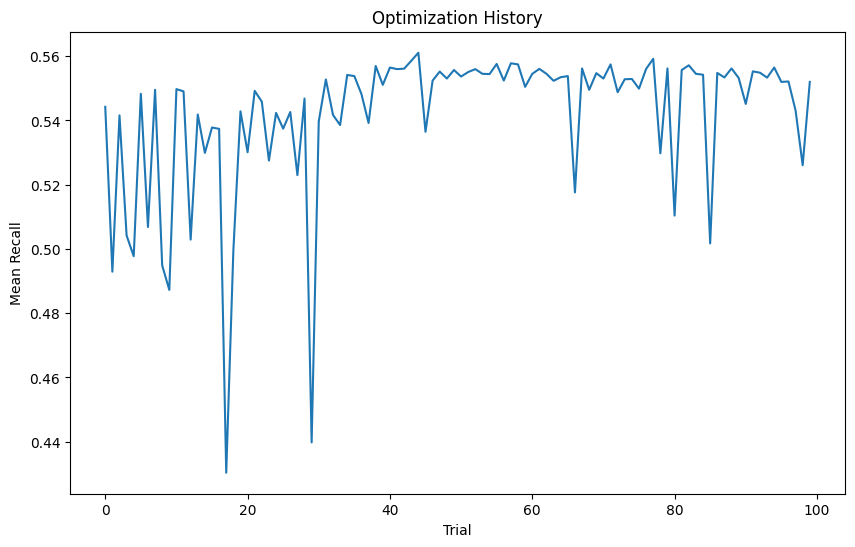

In [260]:
# Optimize hyperparameters for balanced dataset
print("Optimizing XGBoost hyperparameters for balanced dataset...")
best_params_balanced = optimize_xgboost(
    X_train_balanced, y_train_balanced,
    X_val_balanced, y_val_balanced,
    n_trials=100
)

# Optimize hyperparameters for unbalanced dataset
print("\nOptimizing XGBoost hyperparameters for unbalanced dataset...")
best_params_unbalanced = optimize_xgboost(
    X_train_unbalanced, y_train_unbalanced,
    X_val_unbalanced, y_val_unbalanced,
    n_trials=100
)

# Add default objective and eval_metric to best parameters
best_params_balanced['objective'] = 'binary:logistic'
best_params_balanced['eval_metric'] = 'auc'
best_params_unbalanced['objective'] = 'binary:logistic'
best_params_unbalanced['eval_metric'] = 'auc'

Evaluating tuned XGBoost model on balanced dataset...

Classification Report - Balanced Dataset
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7578    0.6690    0.7106      4767
           1     0.7037    0.7862    0.7427      4767

    accuracy                         0.7276      9534
   macro avg     0.7308    0.7276    0.7267      9534
weighted avg     0.7308    0.7276    0.7267      9534



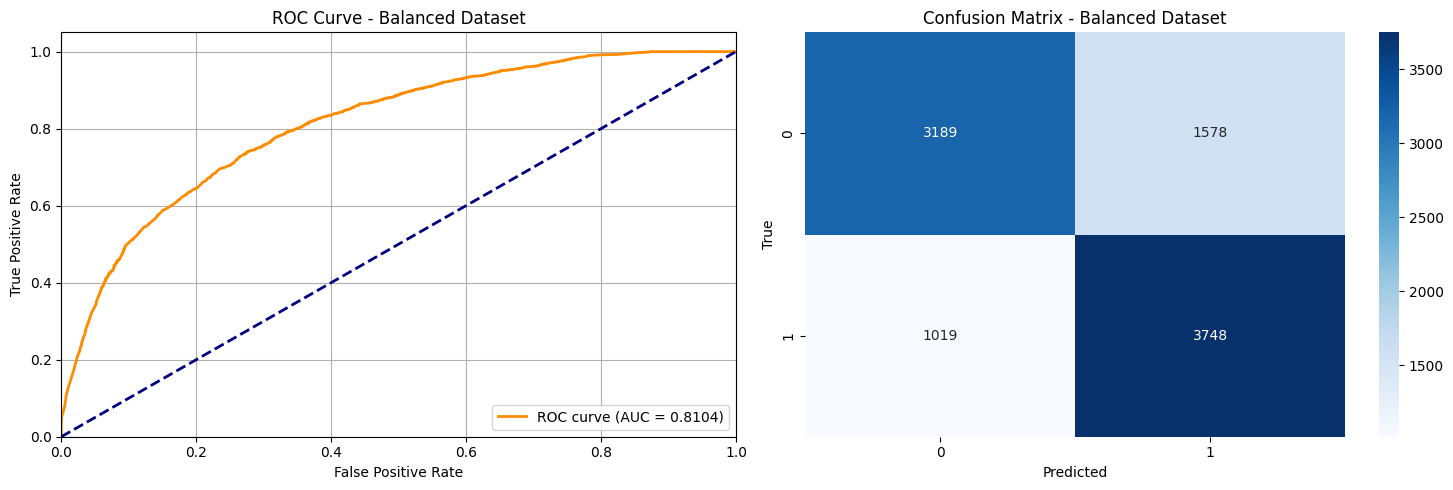

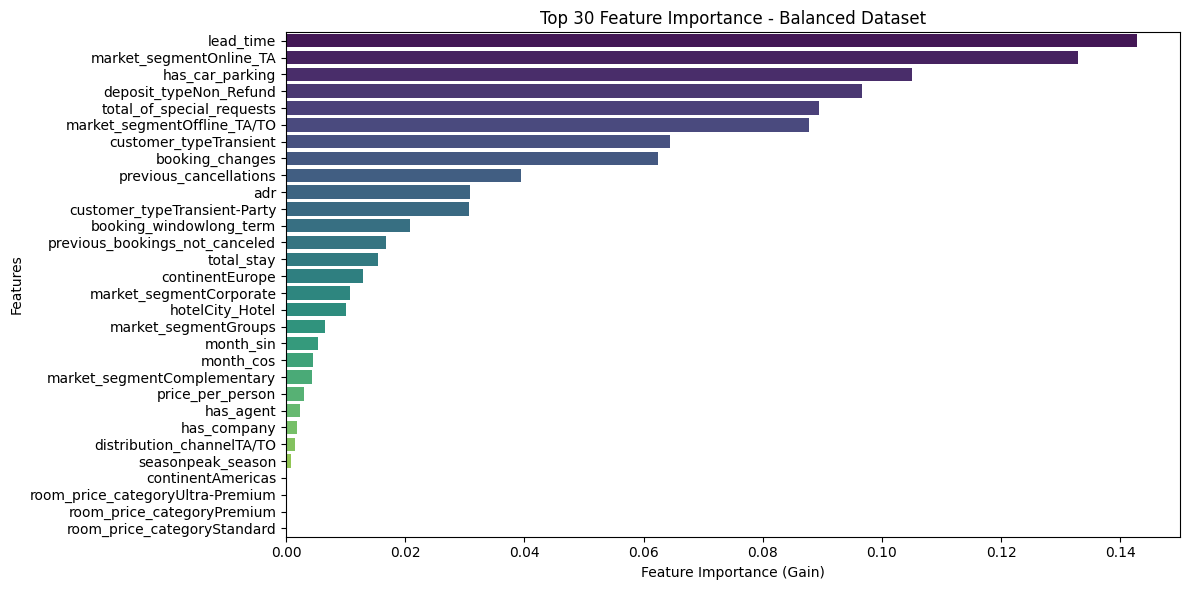


Test Set Metrics Summary:
------------------------------------------------------------
Accuracy: 0.7276
Precision: 0.7037
Recall: 0.7862
F1: 0.7427
Auc Roc: 0.8104

Evaluating tuned XGBoost model on unbalanced dataset...

Classification Report - Unbalanced Dataset
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8366    0.8864    0.8608     12434
           1     0.6492    0.5486    0.5947      4767

    accuracy                         0.7927     17201
   macro avg     0.7429    0.7175    0.7277     17201
weighted avg     0.7847    0.7927    0.7870     17201



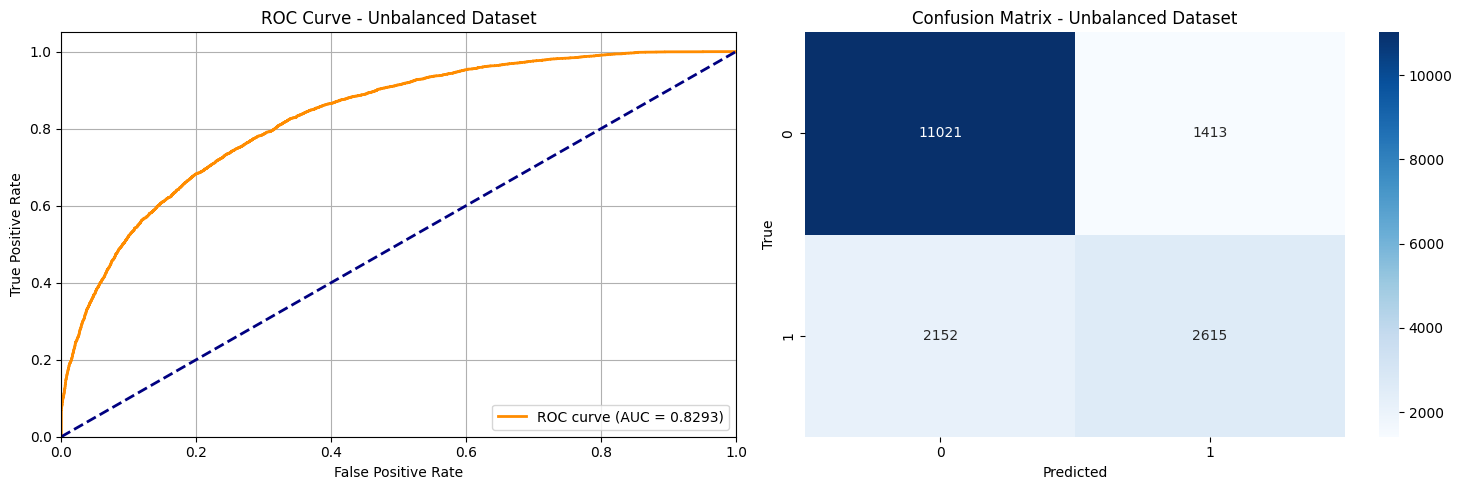

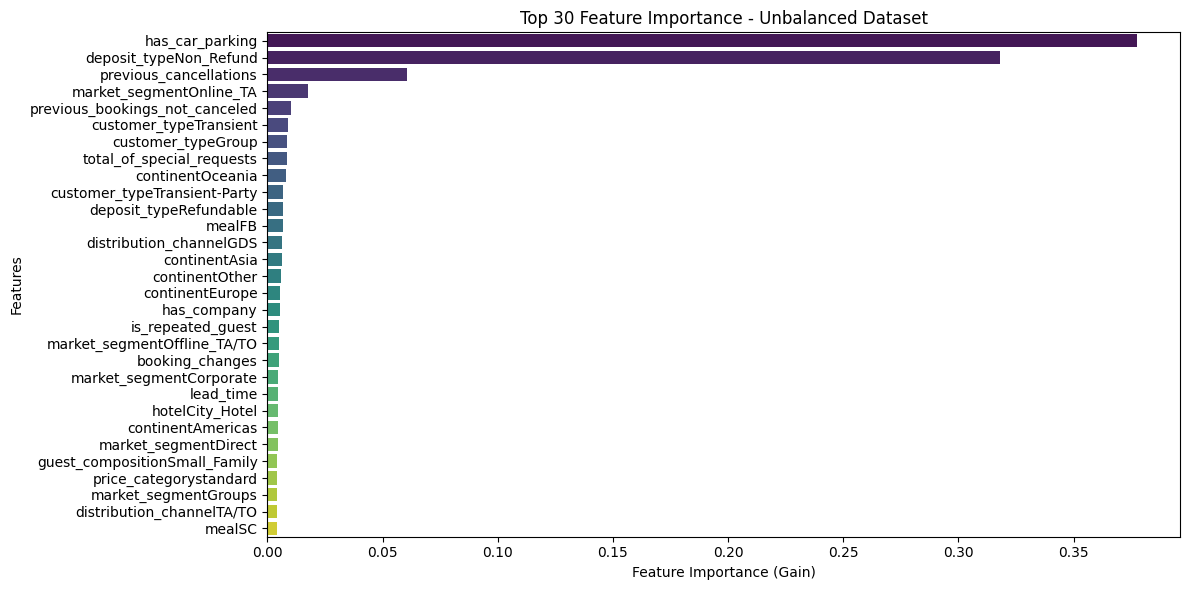


Test Set Metrics Summary:
------------------------------------------------------------
Accuracy: 0.7927
Precision: 0.6492
Recall: 0.5486
F1: 0.5947
Auc Roc: 0.8293


In [266]:
# Evaluate tuned models on test sets and create visualizations
def evaluate_tuned_model(model, X_test, y_test, dataset_name=""):

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Print classification report
    print(f"\nClassification Report - {dataset_name}")
    print("-" * 60)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve - {dataset_name}')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title(f'Confusion Matrix - {dataset_name}')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance
    n_features = 30  # Number of top features to show
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(n_features), 
                x='importance', y='feature', palette='viridis')
    plt.title(f'Top {n_features} Feature Importance - {dataset_name}')
    plt.xlabel('Feature Importance (Gain)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Return the metrics dictionary
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc_roc': roc_auc
    }
    
    print("\nTest Set Metrics Summary:")
    print("-" * 60)
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    
    return metrics

# Evaluate tuned model on balanced dataset
print("Evaluating tuned XGBoost model on balanced dataset...")
balanced_metrics = evaluate_tuned_model(
    xgb_model_balanced_tuned, 
    X_test_balanced, 
    y_test_balanced,
    "Balanced Dataset"
)

# Evaluate tuned model on unbalanced dataset
print("\nEvaluating tuned XGBoost model on unbalanced dataset...")
unbalanced_metrics = evaluate_tuned_model(
    xgb_model_unbalanced_tuned, 
    X_test_unbalanced, 
    y_test_unbalanced,
    "Unbalanced Dataset"
)

In [267]:
def get_top_n_features(model, feature_names, n=8):

    # Get feature importance
    importance_dict = dict(zip(feature_names, model.feature_importances_))
    # Sort features by importance
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    # Get top n feature names
    top_features = [feat[0] for feat in sorted_features[:30]]
    
    print(f"\nTop {n} features selected:")
    for i, (feat, importance) in enumerate(sorted_features[:30], 1):
        print(f"{i}. {feat}: {importance:.4f}")
        
    return top_features

In [268]:
def evaluate_model_comprehensive(y_true, y_pred, y_pred_proba, title="Model Evaluation"):

    # Create figure for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix\n{title}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve\n{title}')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # 3. Classification Report
    print("\nClassification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, digits=4))
    
    # 4. Additional Metrics
    print("\nAdditional Metrics:")
    print("-" * 60)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")

In [269]:
def train_evaluate_top_features(X_train, X_val, X_test, 
                              y_train, y_val, y_test, 
                              best_params, feature_names,
                              n_features=30, title=""):
    """
    Train and evaluate XGBoost model using only top n features.
    """
    # First, train a model on all features to get feature importance
    print(f"\nTraining initial model to identify top {n_features} features...")
    initial_model = xgb.XGBClassifier(**best_params)
    initial_model.fit(X_train, y_train)
    
    # Get top features
    top_features = get_top_n_features(initial_model, feature_names, n_features)
    
    # Create datasets with only top features
    X_train_top = X_train[top_features]
    X_val_top = X_val[top_features]
    X_test_top = X_test[top_features]
    
    # Train final model with top features
    print("\nTraining final model with top features...")
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(
        X_train_top, y_train,
        eval_set=[(X_val_top, y_val)],
        verbose=False
    )
    
    # Make predictions
    y_pred = final_model.predict(X_test_top)
    y_pred_proba = final_model.predict_proba(X_test_top)[:, 1]
    
    # Evaluate model
    print(f"\nEvaluation Results for {title}")
    print("=" * 60)
    evaluate_model_comprehensive(y_test, y_pred, y_pred_proba, 
                               f"XGBoost with Top {n_features} Features - {title}")
    
    return final_model, top_features

Running model with top features for balanced dataset...

Training initial model to identify top 30 features...

Top 30 features selected:
1. lead_time: 0.1111
2. distribution_channelTA/TO: 0.1039
3. market_segmentOnline_TA: 0.1032
4. deposit_typeNon_Refund: 0.1000
5. total_of_special_requests: 0.0848
6. has_car_parking: 0.0813
7. market_segmentOffline_TA/TO: 0.0812
8. customer_typeTransient: 0.0537
9. booking_windowlong_term: 0.0410
10. market_segmentGroups: 0.0372
11. booking_changes: 0.0351
12. booking_windowmedium_term: 0.0296
13. adr: 0.0292
14. customer_typeTransient-Party: 0.0288
15. previous_cancellations: 0.0234
16. total_stay: 0.0147
17. previous_bookings_not_canceled: 0.0135
18. market_segmentCorporate: 0.0108
19. month_cos: 0.0057
20. hotelCity_Hotel: 0.0052
21. has_company: 0.0035
22. price_categorypremium: 0.0022
23. price_per_person: 0.0009
24. is_repeated_guest: 0.0000
25. days_in_waiting_list_log: 0.0000
26. has_agent: 0.0000
27. month_sin: 0.0000
28. hotelResort_Hotel:

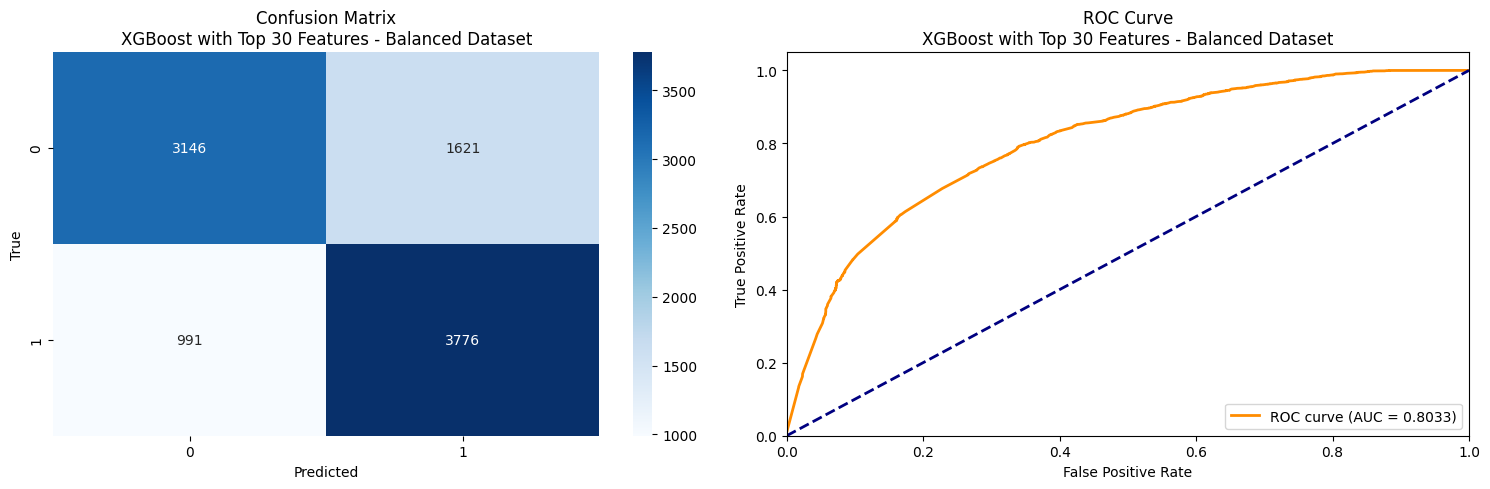


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7605    0.6600    0.7066      4767
           1     0.6996    0.7921    0.7430      4767

    accuracy                         0.7260      9534
   macro avg     0.7301    0.7260    0.7248      9534
weighted avg     0.7301    0.7260    0.7248      9534


Additional Metrics:
------------------------------------------------------------
Accuracy: 0.7260
ROC AUC: 0.8033


In [340]:
# Run for balanced dataset
print("Running model with top features for balanced dataset...")
model_balanced_top, top_features_balanced = train_evaluate_top_features(
    X_train_balanced, X_val_balanced, X_test_balanced,
    y_train_balanced, y_val_balanced, y_test_balanced,
    best_params_balanced, feature_names,
    n_features=30, title="Balanced Dataset"
)

Deep Neural Network with Differential Evolution and Optuna for hyperparameter tuning.

In [328]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pandas as pd

In [329]:
# Data Loading and Splitting

def load_and_split_data(df, test_size=0.2, val_size=0.25, random_state=42):
    X = df.drop('is_canceled', axis=1).values
    y = df['is_canceled'].values

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [330]:
def create_dataloader(X, y, batch_size, shuffle=True, device='cuda'):
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    # Create TensorDataset
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    
    # Create DataLoader with drop_last=True to avoid single-sample batches
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True  
    )
    
    return dataloader

In [331]:
class HotelNN(nn.Module):
    def __init__(self, input_dim, dropout_p=0.5):
        super(HotelNN, self).__init__()
        # Simplified architecture based on input dimensionality
        self.fc1 = nn.Linear(input_dim, 256) 
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_p)
        self.out = nn.Linear(128, 1)  
        
    def forward(self, x):
        # Handle both single-sample and multi-sample batches
        if x.size(0) > 1:  
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
        else:  
            x = F.relu(self.fc1(x))
            x = self.dropout1(x)
            x = F.relu(self.fc2(x))
            x = self.dropout2(x)
        return self.out(x)

In [332]:
# Training and Evaluation

def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader.dataset), accuracy

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

def plot_metrics(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(labels, [p[0] for p in preds])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [333]:
# Hyperparameter Optimization

def optuna_objective(trial, X_train, y_train, device):
    
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout_p = trial.suggest_float("dropout_p", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[valid_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[valid_idx]

        scaler = StandardScaler()
        X_fold_train = scaler.fit_transform(X_fold_train)
        X_fold_val = scaler.transform(X_fold_val)

        train_loader = create_dataloader(X_fold_train, y_fold_train, batch_size, device=device)
        val_loader = create_dataloader(X_fold_val, y_fold_val, batch_size, shuffle=False, device=device)

        input_dim = X_fold_train.shape[1]
        model = HotelNN(input_dim, dropout_p).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        for _ in range(10):
            train_one_epoch(model, optimizer, criterion, train_loader, device)

        accuracy, _, _ = evaluate(model, val_loader, device)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)


In [336]:
def optuna_objective(trial, X_train, y_train, device):
    # Hyperparameter search space
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout_p = trial.suggest_float("dropout_p", 0.2, 0.6)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[valid_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[valid_idx]

        scaler = StandardScaler()
        X_fold_train = scaler.fit_transform(X_fold_train)
        X_fold_val = scaler.transform(X_fold_val)

        train_loader = create_dataloader(X_fold_train, y_fold_train, batch_size, device=device)
        val_loader = create_dataloader(X_fold_val, y_fold_val, batch_size, shuffle=False, device=device)

        input_dim = X_fold_train.shape[1]
        model = HotelNN(input_dim, dropout_p).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        for _ in range(10):
            train_one_epoch(model, optimizer, criterion, train_loader, device)

        accuracy, _, _ = evaluate(model, val_loader, device)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)

print("Starting hyperparameter tuning for balanced dataset...")
study_bal = optuna.create_study(direction="maximize")
study_bal.optimize(lambda trial: optuna_objective(trial, X_train_bal, y_train_bal, device), n_trials=50)

best_params_bal = study_bal.best_trial.params
print("Best Parameters for Balanced Dataset:", best_params_bal)

print("Starting hyperparameter tuning for unbalanced dataset...")
study_unbal = optuna.create_study(direction="maximize")
study_unbal.optimize(lambda trial: optuna_objective(trial, X_train_unbal, y_train_unbal, device), n_trials=50)

best_params_unbal = study_unbal.best_trial.params
print("Best Parameters for Unbalanced Dataset:", best_params_unbal)

[I 2024-12-30 23:16:31,172] A new study created in memory with name: no-name-3eca6e2f-07b3-4515-a3df-837b25b3c6ab


Starting hyperparameter tuning for balanced dataset...


[I 2024-12-30 23:16:59,161] Trial 0 finished with value: 0.7532968574635243 and parameters: {'lr': 0.0013875681123326517, 'weight_decay': 0.0004454093492932514, 'dropout_p': 0.20485249317551962, 'batch_size': 32}. Best is trial 0 with value: 0.7532968574635243.
[I 2024-12-30 23:17:14,791] Trial 1 finished with value: 0.7502815315315315 and parameters: {'lr': 0.002140965713237172, 'weight_decay': 0.0009289992474106873, 'dropout_p': 0.48642643396721535, 'batch_size': 64}. Best is trial 0 with value: 0.7532968574635243.
[I 2024-12-30 23:18:07,996] Trial 2 finished with value: 0.7466386554621849 and parameters: {'lr': 0.008013098683249675, 'weight_decay': 4.9472946655664885e-06, 'dropout_p': 0.5269764298692003, 'batch_size': 16}. Best is trial 0 with value: 0.7532968574635243.
[I 2024-12-30 23:19:00,798] Trial 3 finished with value: 0.7488095238095238 and parameters: {'lr': 0.0006928355116499381, 'weight_decay': 7.585710505627503e-06, 'dropout_p': 0.507279310813392, 'batch_size': 16}. Best

Best Parameters for Balanced Dataset: {'lr': 0.002861209623125521, 'weight_decay': 1.6741324193747066e-06, 'dropout_p': 0.2960959174013471, 'batch_size': 128}
Starting hyperparameter tuning for unbalanced dataset...


[I 2024-12-30 23:39:59,327] Trial 0 finished with value: 0.8020348837209302 and parameters: {'lr': 0.000868425913300699, 'weight_decay': 9.892754582690099e-06, 'dropout_p': 0.32443031155966423, 'batch_size': 16}. Best is trial 0 with value: 0.8020348837209302.
[I 2024-12-30 23:41:37,094] Trial 1 finished with value: 0.8018023255813954 and parameters: {'lr': 0.0035832904064531683, 'weight_decay': 1.1322046811509021e-05, 'dropout_p': 0.44852971701877153, 'batch_size': 16}. Best is trial 0 with value: 0.8020348837209302.
[I 2024-12-30 23:43:13,999] Trial 2 finished with value: 0.8009883720930233 and parameters: {'lr': 0.00012080108871295286, 'weight_decay': 2.6352858132449536e-06, 'dropout_p': 0.36000943387563666, 'batch_size': 16}. Best is trial 0 with value: 0.8020348837209302.
[I 2024-12-30 23:44:49,491] Trial 3 finished with value: 0.7982170542635659 and parameters: {'lr': 0.00010074336657951272, 'weight_decay': 0.0001760598914058172, 'dropout_p': 0.5991468448254584, 'batch_size': 16}

Best Parameters for Unbalanced Dataset: {'lr': 0.0007498837136422305, 'weight_decay': 5.845013605218158e-06, 'dropout_p': 0.3769505172098529, 'batch_size': 64}


In [337]:
def final_model_evaluation(X_train, y_train, X_test, y_test, best_params, dataset_name):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    train_loader = create_dataloader(X_train_scaled, y_train, batch_size=best_params['batch_size'], device=device)
    test_loader = create_dataloader(X_test_scaled, y_test, batch_size=best_params['batch_size'], shuffle=False, device=device)

    model = HotelNN(X_train_scaled.shape[1], best_params['dropout_p']).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

    for epoch in range(50):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
        print(f"Epoch {epoch+1}/50 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    accuracy, preds, labels = evaluate(model, test_loader, device)
    print(f"{dataset_name} Test Accuracy with Tuned Parameters: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(labels, preds, digits=4))
    plot_metrics(labels, preds, dataset_name)

Epoch 1/50 - Train Loss: 0.5423, Train Accuracy: 0.7188
Epoch 2/50 - Train Loss: 0.5121, Train Accuracy: 0.7413
Epoch 3/50 - Train Loss: 0.5078, Train Accuracy: 0.7451
Epoch 4/50 - Train Loss: 0.5000, Train Accuracy: 0.7484
Epoch 5/50 - Train Loss: 0.4987, Train Accuracy: 0.7482
Epoch 6/50 - Train Loss: 0.4959, Train Accuracy: 0.7508
Epoch 7/50 - Train Loss: 0.4911, Train Accuracy: 0.7557
Epoch 8/50 - Train Loss: 0.4903, Train Accuracy: 0.7527
Epoch 9/50 - Train Loss: 0.4886, Train Accuracy: 0.7541
Epoch 10/50 - Train Loss: 0.4861, Train Accuracy: 0.7567
Epoch 11/50 - Train Loss: 0.4841, Train Accuracy: 0.7586
Epoch 12/50 - Train Loss: 0.4833, Train Accuracy: 0.7575
Epoch 13/50 - Train Loss: 0.4809, Train Accuracy: 0.7584
Epoch 14/50 - Train Loss: 0.4794, Train Accuracy: 0.7606
Epoch 15/50 - Train Loss: 0.4783, Train Accuracy: 0.7613
Epoch 16/50 - Train Loss: 0.4764, Train Accuracy: 0.7628
Epoch 17/50 - Train Loss: 0.4746, Train Accuracy: 0.7649
Epoch 18/50 - Train Loss: 0.4738, Train 

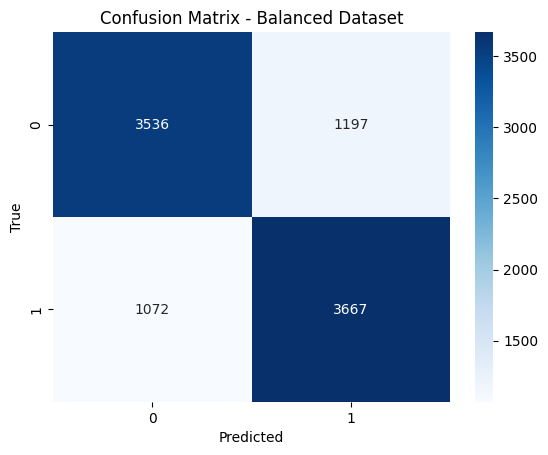

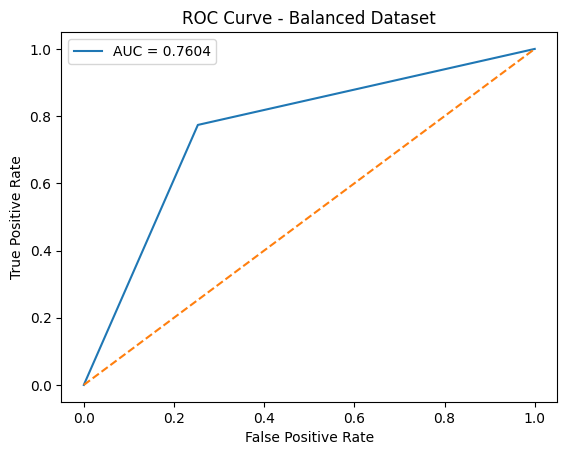

In [338]:
final_model_evaluation(X_train_bal, y_train_bal, X_test_bal, y_test_bal, best_params_bal, "Balanced Dataset")

Epoch 1/50 - Train Loss: 0.4763, Train Accuracy: 0.7742
Epoch 2/50 - Train Loss: 0.4490, Train Accuracy: 0.7905
Epoch 3/50 - Train Loss: 0.4410, Train Accuracy: 0.7961
Epoch 4/50 - Train Loss: 0.4347, Train Accuracy: 0.7993
Epoch 5/50 - Train Loss: 0.4328, Train Accuracy: 0.7993
Epoch 6/50 - Train Loss: 0.4306, Train Accuracy: 0.7997
Epoch 7/50 - Train Loss: 0.4287, Train Accuracy: 0.8011
Epoch 8/50 - Train Loss: 0.4272, Train Accuracy: 0.8007
Epoch 9/50 - Train Loss: 0.4265, Train Accuracy: 0.8026
Epoch 10/50 - Train Loss: 0.4236, Train Accuracy: 0.8032
Epoch 11/50 - Train Loss: 0.4219, Train Accuracy: 0.8025
Epoch 12/50 - Train Loss: 0.4219, Train Accuracy: 0.8027
Epoch 13/50 - Train Loss: 0.4212, Train Accuracy: 0.8043
Epoch 14/50 - Train Loss: 0.4203, Train Accuracy: 0.8039
Epoch 15/50 - Train Loss: 0.4192, Train Accuracy: 0.8043
Epoch 16/50 - Train Loss: 0.4173, Train Accuracy: 0.8073
Epoch 17/50 - Train Loss: 0.4174, Train Accuracy: 0.8061
Epoch 18/50 - Train Loss: 0.4172, Train 

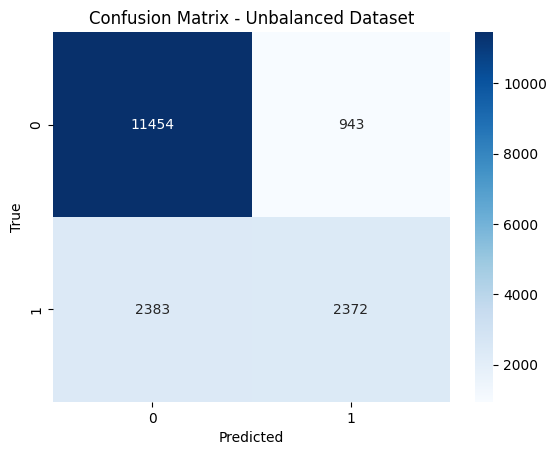

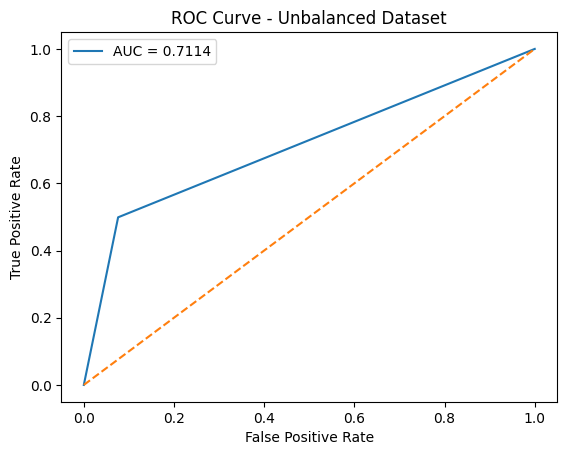

In [339]:
final_model_evaluation(X_train_unbal, y_train_unbal, X_test_unbal, y_test_unbal, best_params_unbal, "Unbalanced Dataset")

## Lecture References

### Week 1: Introduction to Business Analytics
- Implementation follows CRISP-DM methodology introduced in Week 1
- Data understanding and problem definition approaches
- Business analytics project lifecycle structure

### Week 2: Statistical Machine Learning & Regression
- Model evaluation metrics implementation (accuracy, precision, recall, F1-score)
- ROC curves and AUC calculation
- Confusion matrix visualization and interpretation
- Cross-validation methodology for model assessment

### Week 3: Data Preparation
- Data preprocessing pipeline implementation
- Feature engineering and selection techniques
- Handling missing values and outliers
- Data normalization approaches

### Week 4: Supervised Machine Learning
- Classification model implementation
- XGBoost algorithm application
- Model training and evaluation workflows
- Feature importance analysis

### Week 7: Visualization
- Data visualization techniques using seaborn and matplotlib
- Feature importance plotting
- Results presentation using confusion matrices and ROC curves

### Week 8: Optimization
- Hyperparameter tuning implementation
- Model optimization approaches
- Parameter selection based on evaluation metrics